<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI6_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Visualizing computer experiments of multistrain communities

In [1]:
import numpy as np
import os
import csv
import sys
import matplotlib.pyplot as plt
import colorcet as cc
import time
import multiprocessing
import random
from tabulate import tabulate
import itertools
import pickle
from collections import Counter
import seaborn as sns

File structure

In [2]:

num_days = 10
num_experiments = 6
str_E = 'gaussian_noise'
#iEs = [0]




In [3]:
# Define your paths
root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'

path='./'
figPath = path+'figures/'
envPath = path+'env/'
dataPath = path+'data/'


strains_subsetE = [1, 2, 6, 9, 11, 15, 18, 20, 21, 24]
strains_subsetK = [25, 26, 29, 34, 37, 38, 39, 41, 43, 45]

strains_subset = strains_subsetE + strains_subsetK


print("subset: ",strains_subset)

strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
plasmids = ['WT','TC']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]

## Simulation parameters

M_values=range(1,len(strains_subset)+1)
powers = np.arange(0,8)  # array of powers of two exponents
Amax_values=np.power(2, powers)  # calculate 2 raised to each exponent
verbose=False

subset:  [1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir(root)

sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model parameters

In [5]:

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
extinction_threshold=1 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

#display_model_params_stats(model_params)

## Load computer simulations: Serial transfers (Multiple Es)

Here we run the simulations:

In [6]:


def get_sequences_from_files(directory, length=None):
    # Initialize a list to hold the sequences
    sequences = []

    # Loop over each file in the directory
    for filename in os.listdir(directory):
        # Check if the file matches the desired format
        if filename.startswith("sim_Es_") and filename.endswith(".pkl"):
            # Extract the sequence from the filename
            sequence = filename[len("sim_Es_"):-len(".pkl")]

            # Convert sequence string to list of integers
            sequence = list(map(int, sequence.split('_')))

            # Only add to list if no length was specified or the sequence has the correct length
            if length is None or len(sequence) == length:
                sequences.append(sequence)

    return sequences

## Load & Plot

In [7]:

def load_simulation_results(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
    return results["istrains"], results["Es"],  results["Btot"], results["BpEs"], results["BpKs"], results["freqpEs"], results["freqpKs"]


In [8]:
def load_and_plot_As(M, Amax_values, verbose=False):
    expe_Btots = []
    expe_BpEs = []
    expe_BpKs = []
    expe_As = []

    for Amax in Amax_values:
        runPath = './runs/Gaussian_N%s_A%s/' % (num_days, Amax)
        if not os.path.isdir(runPath):
            print(f"Directory {runPath} does not exist. Skipping.")
            continue
        expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))
        for iexpe in range(1, len(expe_istrains)):
            this_istrains = expe_istrains[iexpe]
            this_istrains = this_istrains[:M]  # fix M value
            str_subset = [str(x) for x in this_istrains]  # Convert all elements to string
            sim_lbl = "_".join(str_subset)  # Join elements with "_"
            fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
            filePath = "%s%s" % (runPath, fileName)
            if os.path.isfile(filePath):
                this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_freqpEs, this_freqpKs  = load_simulation_results(filePath)
                if verbose:
                    print("%s: Loading %s" % (iexpe, filePath))

                for j in range(len(this_Btot)):
                    expe_Btots.append(this_Btot[j][-1])  # last value of Btot
                    expe_BpEs.append(this_BpEs[j][-1])  # last value of BpEs
                    expe_BpKs.append(this_BpKs[j][-1])  # last value of BpKs
                    expe_As.append(Amax)
            else:
                if verbose:
                    print("Not found %s" % (filePath))

    plot_final_fraction_As(expe_As, expe_Btots, expe_BpEs, expe_BpKs, M)


def plot_final_fraction_As(expe_As, expe_Btots, expe_BpEs, expe_BpKs, M):
    jitter = 0.2
    # Create a jittered x-values
    expe_As_jittered = expe_As + np.random.uniform(-jitter, jitter, size=len(expe_As))

    # Create the scatter plot
    plt.scatter(expe_As_jittered, expe_Btots, alpha=0.1, color='black', label='Btots')
    plt.scatter(expe_As_jittered, expe_BpEs, alpha=0.1, color='red', label='BpEs')
    plt.scatter(expe_As_jittered, expe_BpKs, alpha=0.1, color='blue', label='BpKs')

    # Calculate the mean for each unique A value
    unique_As = np.unique(expe_As)
    mean_Btots = [np.mean(np.array(expe_Btots)[np.array(expe_As) == A]) for A in unique_As]
    mean_BpEs = [np.mean(np.array(expe_BpEs)[np.array(expe_As) == A]) for A in unique_As]
    mean_BpKs = [np.mean(np.array(expe_BpKs)[np.array(expe_As) == A]) for A in unique_As]

    # Plot the mean frequencies
    plt.scatter(unique_As, mean_Btots, color='black')
    plt.scatter(unique_As, mean_BpEs, color='red')
    plt.scatter(unique_As, mean_BpKs, color='blue')

    # Add labels to the axes
    plt.xlabel('Drug concentration')
    plt.ylabel('Bacterial density')

    # Add a title to the plot
    plt.title('M=%s' % (M))

    plt.xscale('log', base=2)
    plt.legend()
    # Display the plot
    plt.show()


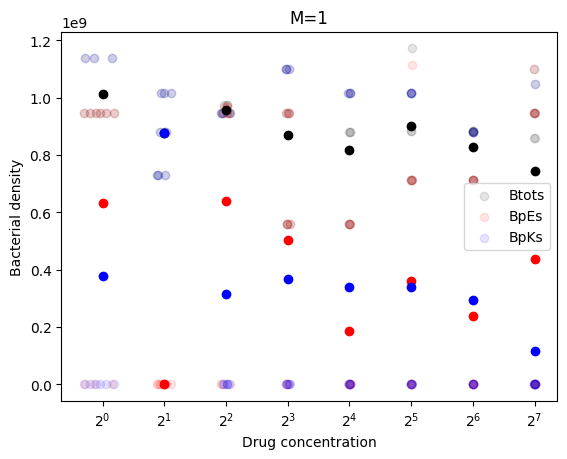

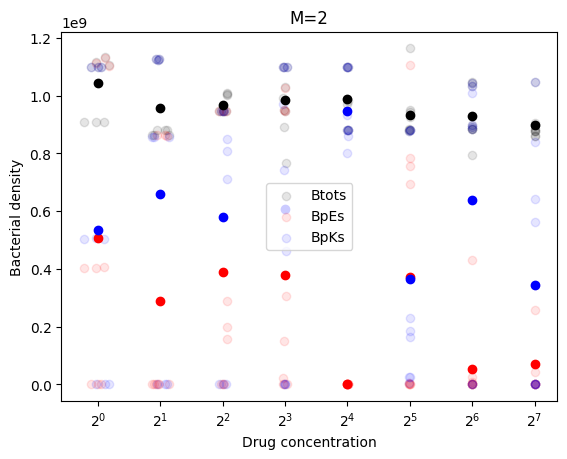

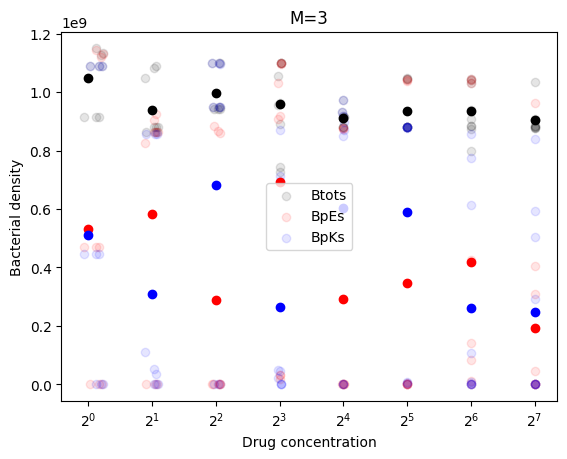

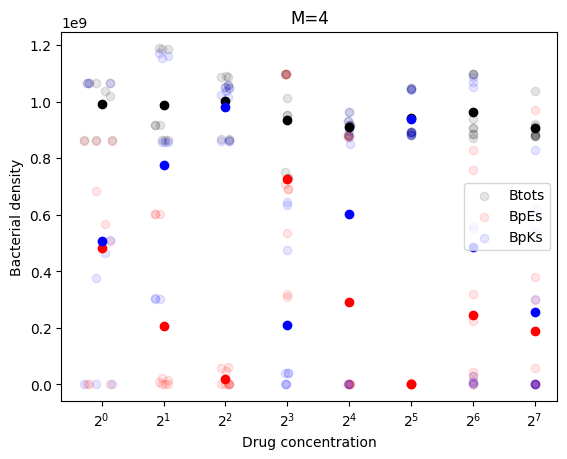

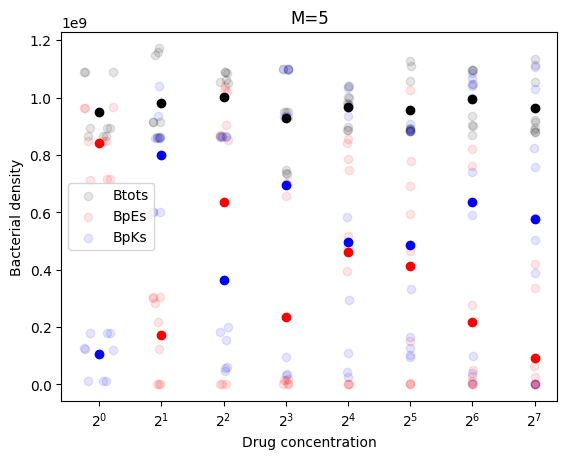

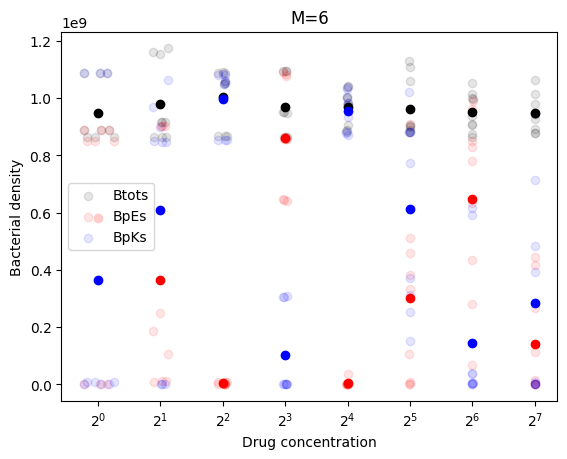

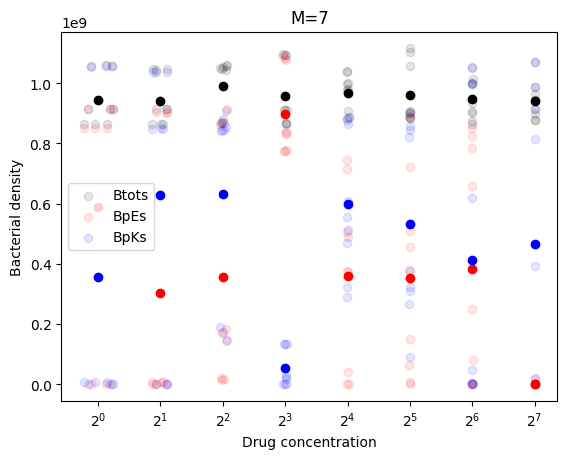

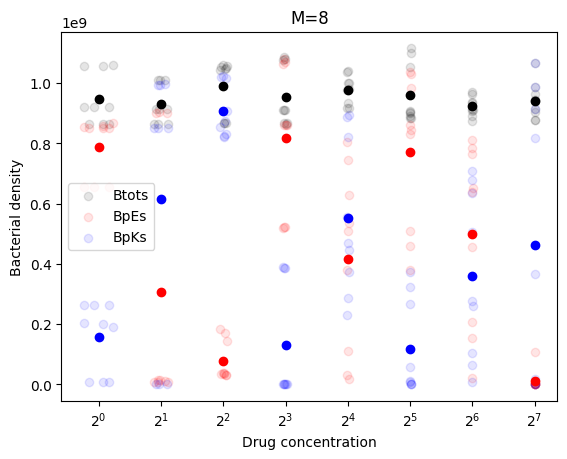

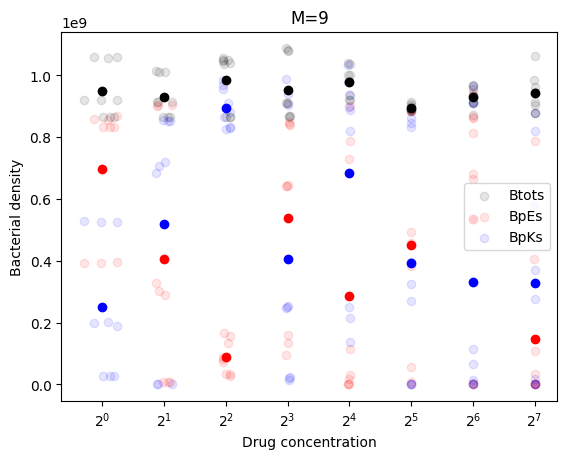

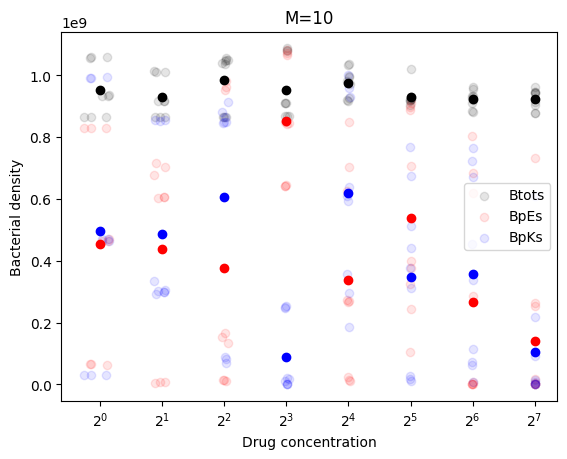

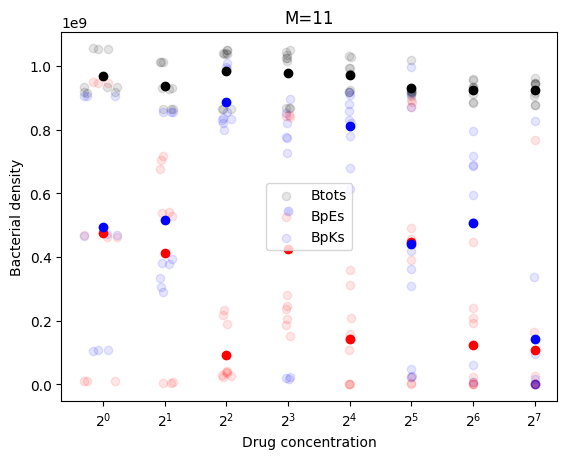

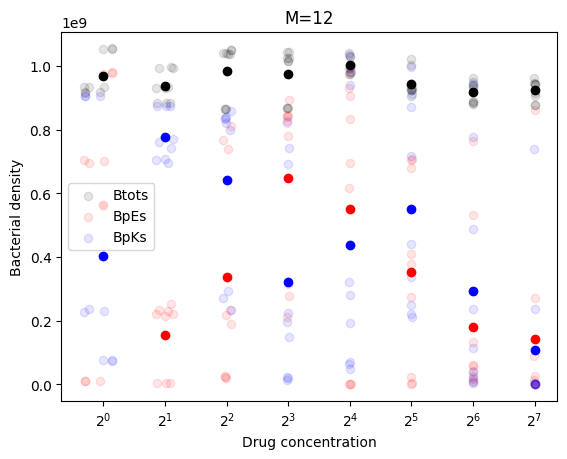

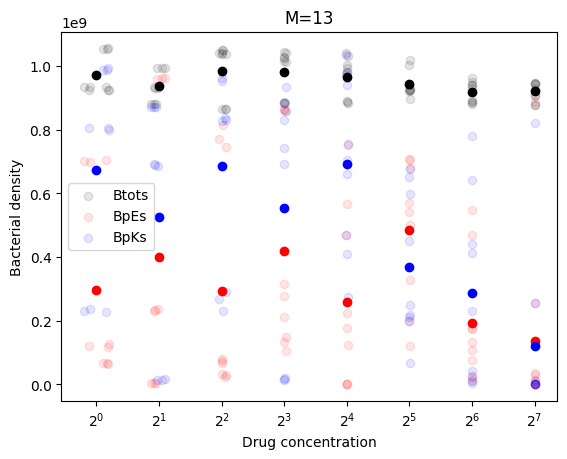

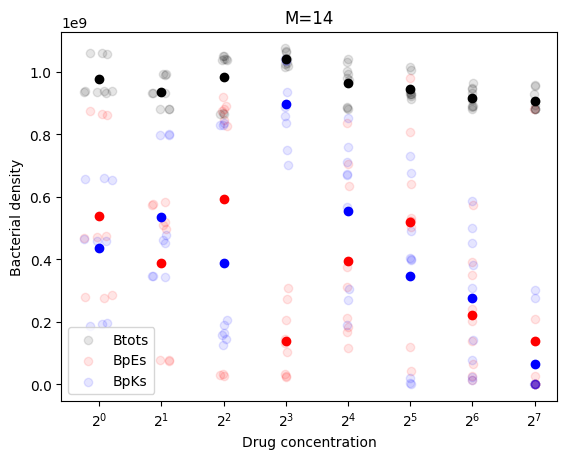

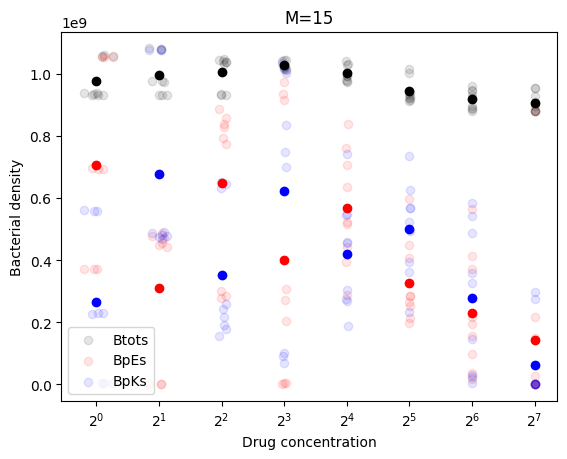

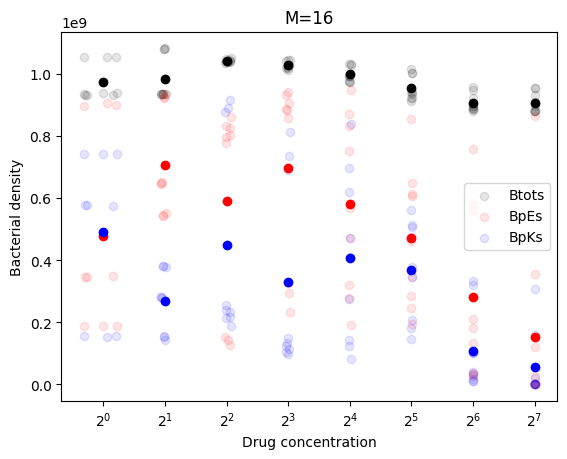

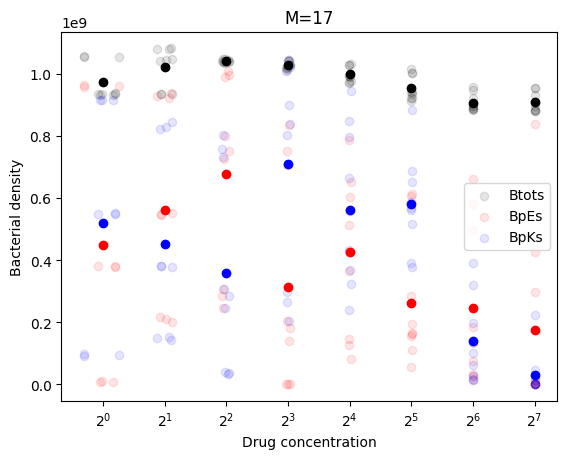

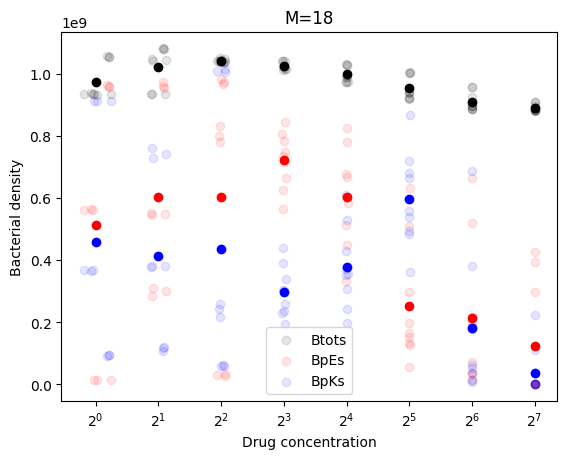

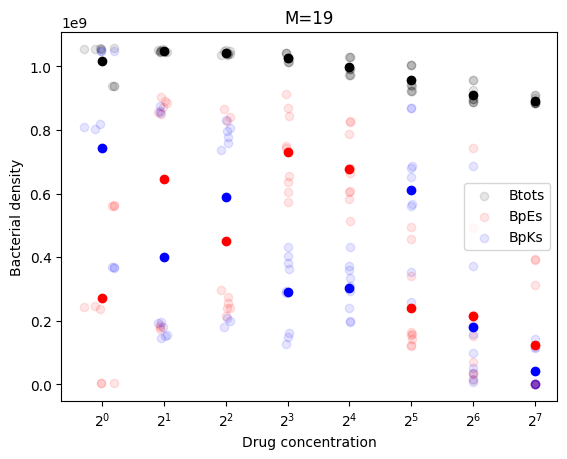

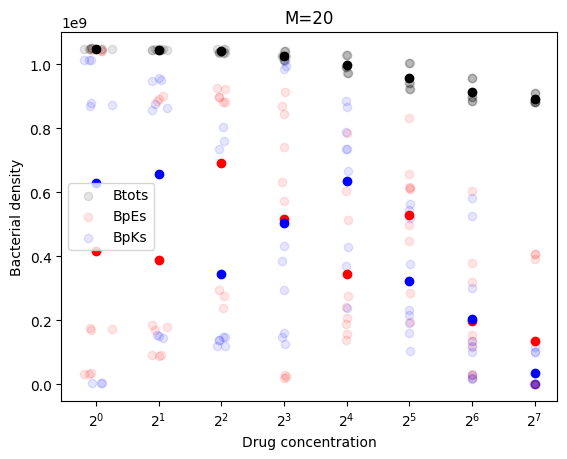

In [9]:
for M in M_values:
  load_and_plot_As(M, Amax_values, verbose=False)

In [10]:
def load_and_plot_A_v_PF(M, Amax_values, verbose=False):
    expe_Amaxs = []
    expe_PF_Es = []
    expe_PF_Ks = []
    expe_PF_total = []

    for Amax in Amax_values:
        runPath = './runs/Gaussian_N%s_A%s/' % (num_days, Amax)
        if not os.path.isdir(runPath):
            print(f"Directory {runPath} does not exist. Skipping.")
            continue
        expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))
        for iexpe in range(1, len(expe_istrains)):
            this_istrains = expe_istrains[iexpe]
            this_istrains = this_istrains[:M]  # fix M value
            str_subset = [str(x) for x in this_istrains]  # Convert all elements to string
            sim_lbl = "_".join(str_subset)  # Join elements with "_"
            fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
            filePath = "%s%s" % (runPath, fileName)
            if os.path.isfile(filePath):

                this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_freqpEs, this_freqpKs  = load_simulation_results(filePath)
                if verbose:
                    print("%s: Loading %s" % (iexpe, filePath))

                for j in range(len(this_Btot)):
                    #final_density = this_Btot[j][-1]  # final total density
                    final_BpEs = this_BpEs[j][-1]  # final BpEs
                    final_BpKs = this_BpKs[j][-1]  # final BpKs
                    final_density = final_BpEs+final_BpKs

                    if final_density>1e-6:
                      final_pf_Es = final_BpEs #/ final_density
                      final_pf_Ks = final_BpKs #/ final_density
                      final_pf_total = (final_pf_Es + final_pf_Ks) #/ final_density
                    else:
                      final_pf_Es = np.nan
                      final_pf_Ks = np.nan
                      final_pf_total = np.nan


                    expe_Amaxs.append(Amax)
                    expe_PF_Es.append(final_pf_Es)
                    expe_PF_Ks.append(final_pf_Ks)
                    expe_PF_total.append(final_pf_total)
            else:
                if verbose:
                    print("Not found %s" % (filePath))

    plot_final_fraction_As(expe_Amaxs, expe_PF_Es, expe_PF_Ks, expe_PF_total, M)




def plot_final_fraction_As(expe_As, expe_PF_Es, expe_PF_Ks, expe_PF_total, M):
    jitter = 0.2
    # Create a jittered x-values
    expe_As_jittered = expe_As + np.random.uniform(-jitter, jitter, size=len(expe_As))


    # Create the scatter plot
    plt.scatter(expe_As_jittered, expe_PF_Es, alpha=0.1, color='red', label='BpEs')
    plt.scatter(expe_As_jittered, expe_PF_Ks, alpha=0.1, color='blue', label='BpKs')
    plt.scatter(expe_As_jittered, expe_PF_total, alpha=0.1, color='black', label='Total')



    # Calculate the mean for each unique A value
    unique_As = np.unique(expe_As)
    mean_PF_Es = [np.nanmean(np.array(expe_PF_Es)[np.array(expe_As) == A]) for A in unique_As]
    mean_PF_Ks = [np.nanmean(np.array(expe_PF_Ks)[np.array(expe_As) == A]) for A in unique_As]
    mean_PF_total = [np.nanmean(np.array(expe_PF_total)[np.array(expe_As) == A]) for A in unique_As]

    # Plot the mean frequencies
    plt.plot(unique_As, mean_PF_Es, color='red')
    plt.plot(unique_As, mean_PF_Ks, color='blue')
    plt.plot(unique_As, mean_PF_total, color='black')

    # Add labels to the axes
    plt.xlabel('Drug concentration')
    plt.ylabel('Plasmid Frequency')

    # Add a title to the plot
    plt.title('M=%s' % (M))

    plt.xscale('log', base=2)
    plt.legend()
    # Display the plot
    plt.show()


1: Loading ./runs/Gaussian_N10_A1/sim_Es_38.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9.pkl
2: Loading ./runs/Gaussian_N10_A32/sim_Es_39.pkl
3: Loading ./runs/Gaussian_N10_A32/sim_Es_18.pkl
1: Loading ./runs/Gaussian_N10_A64/sim_Es_25.pkl
2: Loading ./runs/Gaussian_N10_A64/sim_Es_18.pkl
3: Loading ./runs/Gaussian_N10_A64/

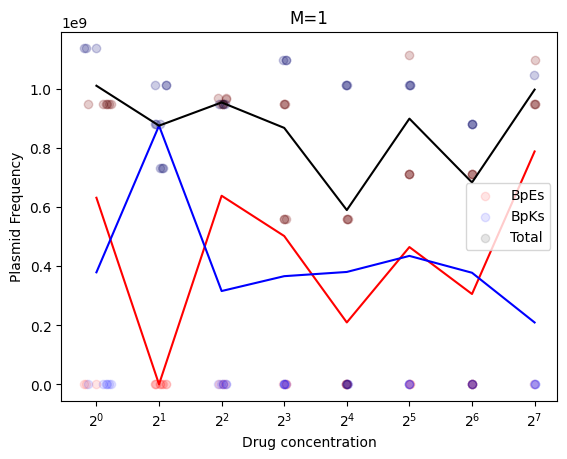

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9_25.pkl
2: Loading ./runs/Gaussian_N10_A32/sim_Es_39_11.pkl
3: Loading ./runs/Gaussian_N10_A32/sim_Es_18_26.pkl
1: Loading ./runs/Gaussian_N10_A64/sim_Es_25_38.pkl
2: Loading ./runs/Gaussian_N10

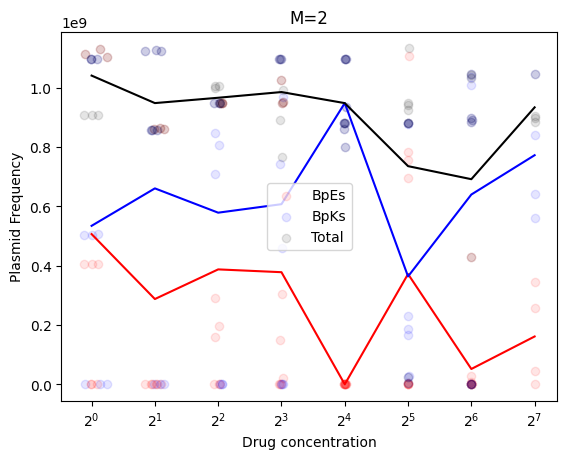

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9_25_41.pkl
2: Loading ./runs/Gaussian_N10_A32/sim_Es_39_11_37.pkl
3: Loading ./runs/Gaussian_N10_A32/sim_Es_18_26_25.pkl
1: Loading ./runs/Gaussian_N10

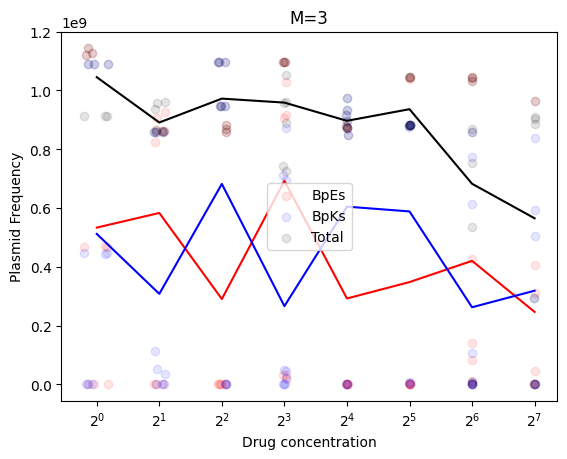

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21_45.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9_25_41_37.pkl
2: Loading ./runs/Gaussian_N10_A32/sim_Es_39_11_37_20.pkl
3: Loading ./runs/Gaussian_N10_A32/s

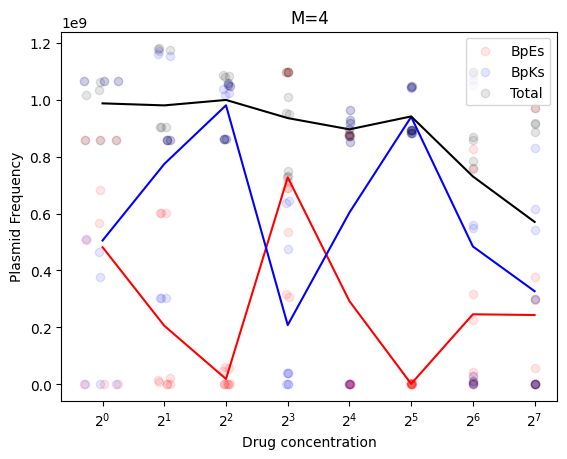

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34_20.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21_45_37.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9_25_41_37_20.pkl
2: Loading ./runs/Gaussian_N10_A32/sim_Es_39_11_3

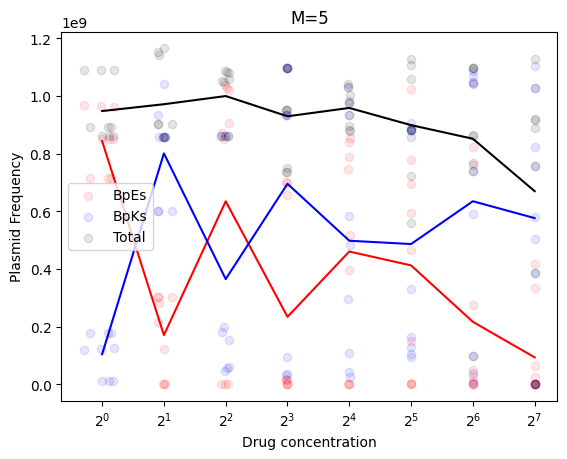

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34_20_38.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21_45_37_18.pkl
1: Loading ./runs/Gaussian_N10_A32/sim_Es_9_25_41_37_20_45.pkl
2: L

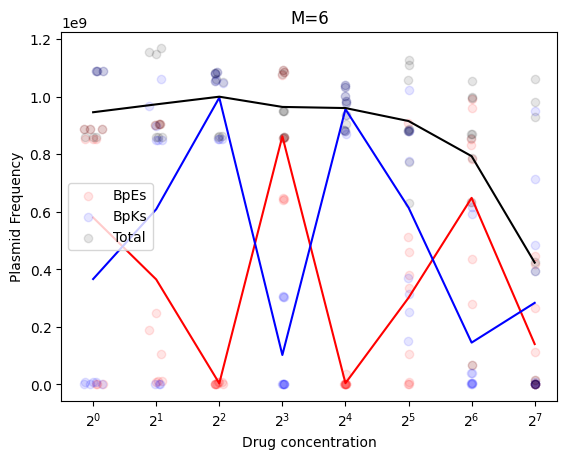

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39_21.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34_20_38_24.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21_45_37_18_39.pkl
1: Loading ./runs/Gauss

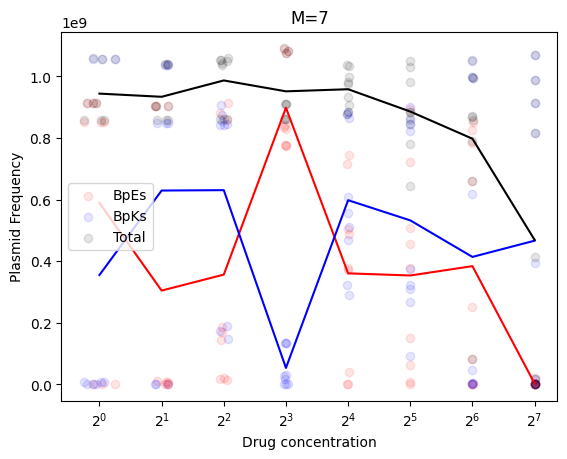

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39_21_9.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34_20_38_24_15.pkl
3: Loading ./runs/Gaussian_N10_A16/sim_Es_20_25_21_

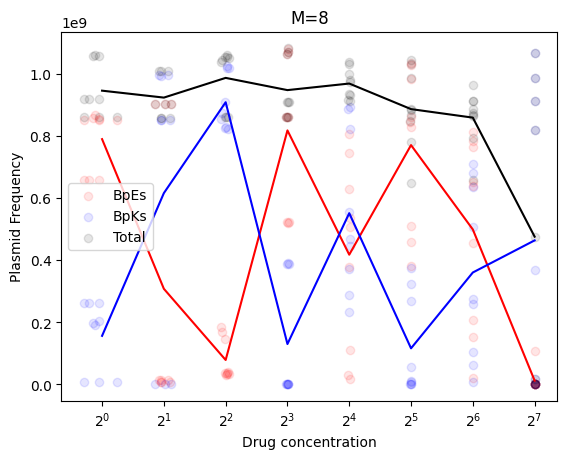

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39_21_9_37.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43_25_34_20_38_24_15_18.pkl
3: Loading .

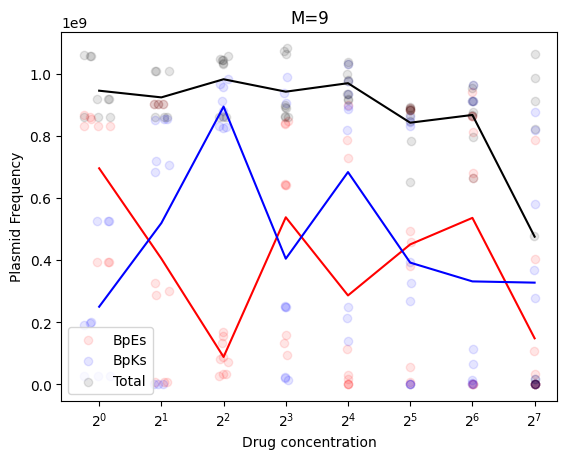

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29_37.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39_21_9_37_29.pkl
2: Loading ./runs/Gaussian_N10_A16/sim_Es_39_43

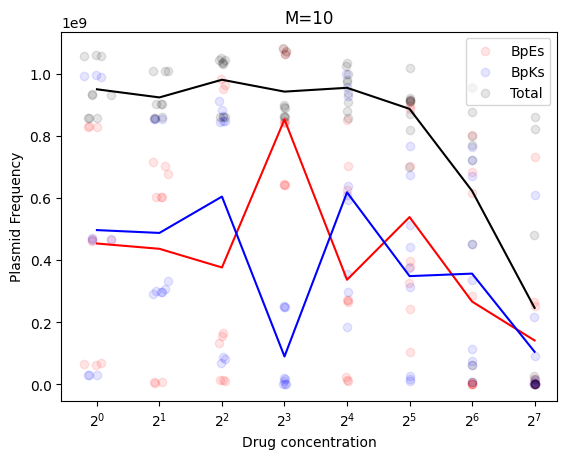

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29_37_15.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41_43_39_21_9_37_29_26.pkl
2: Loading

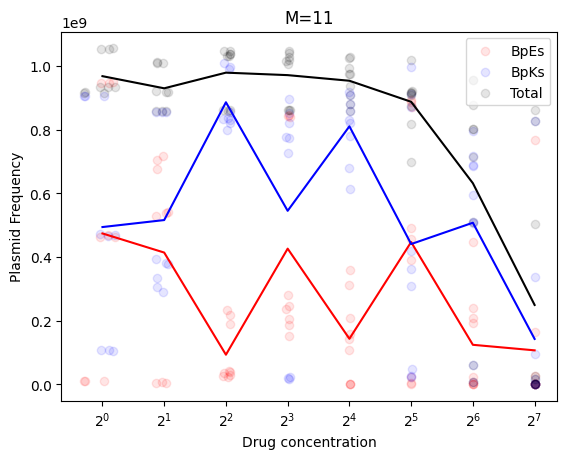

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29_37_15_21.pkl
1: Loading ./runs/Gaussian_N10_A16/sim_Es_2_34_25_41

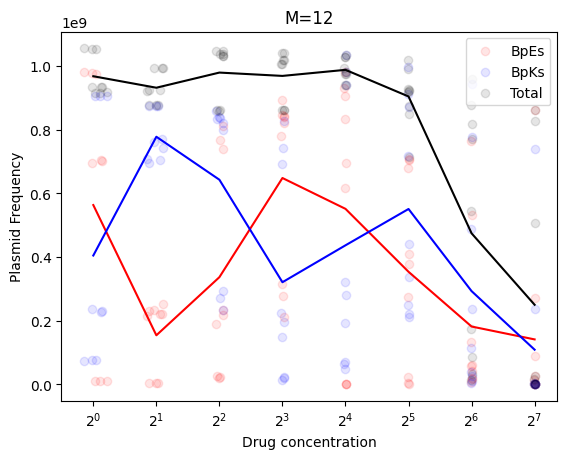

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29_39.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29_37_15_21_43.pkl
1: Loading ./runs/G

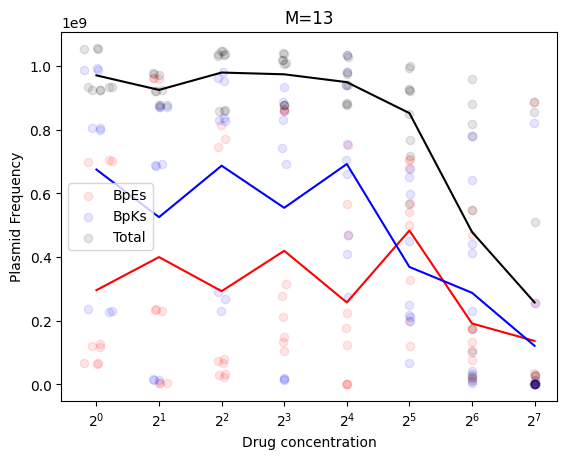

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29_39_37.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_45_26_11_41_6_34_9_29_37_15_

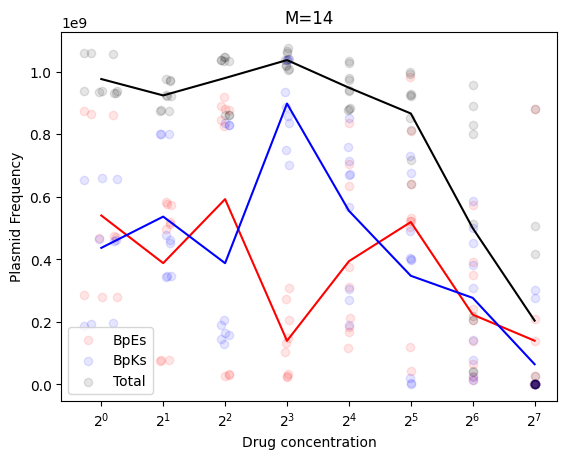

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29_39_37_11.pkl
3: Loading ./runs/Gaussian_N10_A8/sim_Es_20_

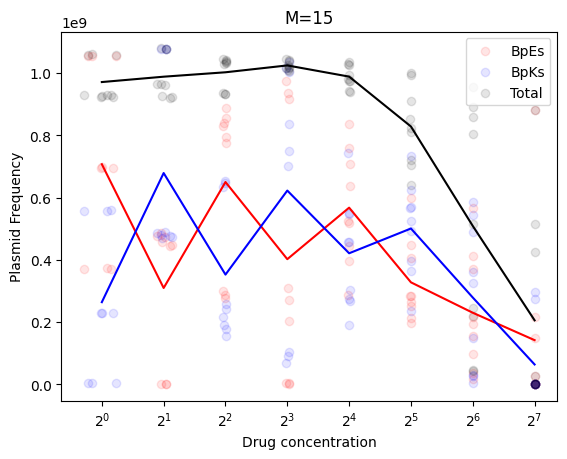

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21_24.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2_15.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2_20.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1_29.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2_1.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29_25.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34_20.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1_43.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15_18.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15_6.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29_39_37_11_38.pkl
3: Loading ./

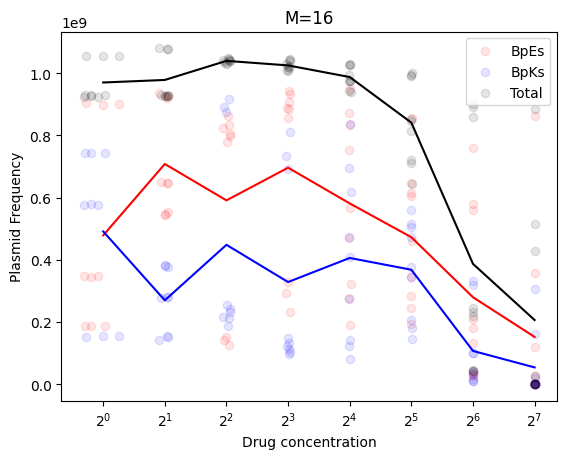

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21_24_6.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2_15_9.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2_20_15.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1_29_38.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2_1_11.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29_25_43.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34_20_21.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1_43_9.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15_18_26.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15_6_9.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_1_45_9_2_6_34_20_41_25_29_39_

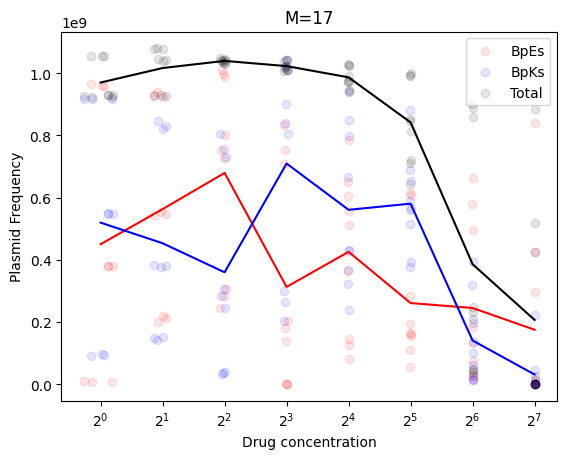

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21_24_6_41.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2_15_9_20.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2_20_15_38.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1_29_38_45.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2_1_11_9.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29_25_43_15.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34_20_21_37.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1_43_9_11.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15_18_26_41.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15_6_9_21.pkl
2: Loading ./runs/Gaussian_N10_A8/sim_Es_43_26_

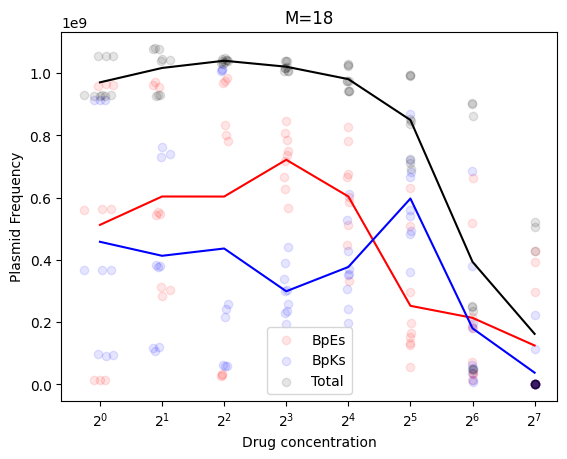

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21_24_6_41_2.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2_15_9_20_39.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2_20_15_38_43.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1_29_38_45_43.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2_1_11_9_25.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29_25_43_15_6.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34_20_21_37_41.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1_43_9_11_24.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15_18_26_41_20.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15_6_9_21_37.pkl
2: Loading ./runs/G

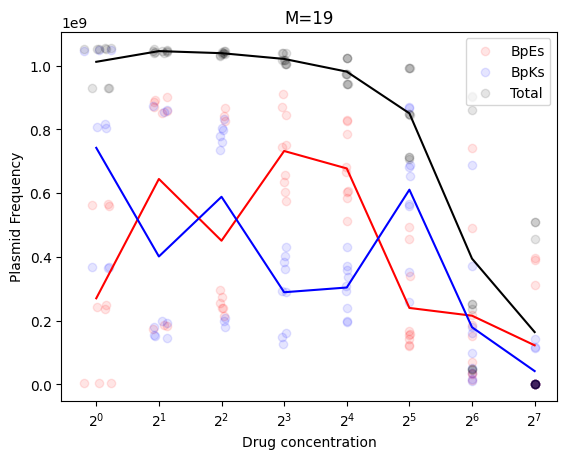

1: Loading ./runs/Gaussian_N10_A1/sim_Es_38_43_37_34_20_39_25_11_45_15_9_26_18_1_21_24_6_41_2_29.pkl
2: Loading ./runs/Gaussian_N10_A1/sim_Es_24_18_21_6_37_45_38_26_25_11_1_41_29_34_2_15_9_20_39_43.pkl
3: Loading ./runs/Gaussian_N10_A1/sim_Es_24_25_45_18_11_9_34_1_6_37_39_21_41_26_2_20_15_38_43_29.pkl
1: Loading ./runs/Gaussian_N10_A2/sim_Es_25_2_20_34_9_11_18_39_41_15_37_24_21_6_1_29_38_45_43_26.pkl
2: Loading ./runs/Gaussian_N10_A2/sim_Es_39_6_15_18_21_24_41_26_34_45_38_43_20_37_2_1_11_9_25_29.pkl
3: Loading ./runs/Gaussian_N10_A2/sim_Es_26_38_21_18_37_45_11_34_1_20_39_24_2_9_29_25_43_15_6_41.pkl
1: Loading ./runs/Gaussian_N10_A4/sim_Es_24_1_2_43_18_26_25_45_29_38_15_6_9_11_34_20_21_37_41_39.pkl
2: Loading ./runs/Gaussian_N10_A4/sim_Es_29_39_41_6_37_15_25_21_45_20_18_38_26_34_1_43_9_11_24_2.pkl
3: Loading ./runs/Gaussian_N10_A4/sim_Es_1_39_43_25_21_37_11_38_34_2_29_45_6_9_15_18_26_41_20_24.pkl
1: Loading ./runs/Gaussian_N10_A8/sim_Es_24_18_38_29_1_20_25_26_2_39_43_11_34_45_15_6_9_21_

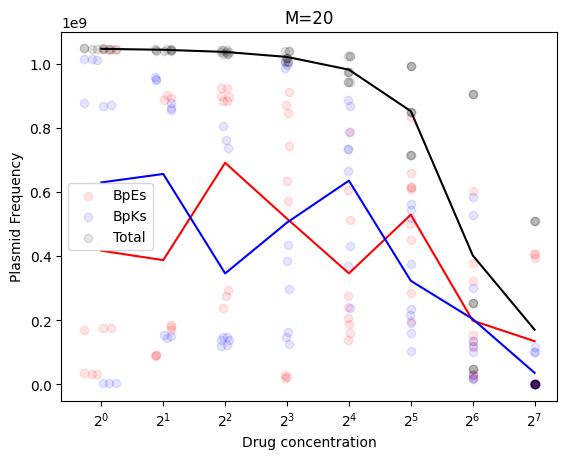

In [11]:
for M in M_values:
  load_and_plot_A_v_PF(M, Amax_values, verbose=True)

In [12]:


def load_and_plot_survival(M, Amax_values, verbose=False):
    expe_Amaxs = []
    expe_survival = []

    for Amax in Amax_values:
        runPath = './runs/Gaussian_N%s_A%s/' % (num_days, Amax)
        if not os.path.isdir(runPath):
            print(f"Directory {runPath} does not exist. Skipping.")
            continue
        expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))
        total_experiments = 0
        survived_experiments = 0
        for iexpe in range(np.min([num_experiments, len(expe_istrains)])):
            this_istrains = expe_istrains[iexpe]
            this_istrains = this_istrains[:M]  # fix M value
            str_subset = [str(x) for x in this_istrains]  # Convert all elements to string
            sim_lbl = "_".join(str_subset)  # Join elements with "_"
            fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
            filePath = "%s%s" % (runPath, fileName)
            if os.path.isfile(filePath):
                this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_freqpEs, this_freqpKs  = load_simulation_results(filePath)
                if verbose:
                    print("%s: Loading %s" % (iexpe, filePath))

                for j in range(len(this_Btot)):
                    this_density = this_Btot[j][-1]  # final total density
                    total_experiments += 1
                    if this_density > 1e-6:  # extinction_threshold
                        survived_experiments += 1
        expe_Amaxs.append(Amax)
        expe_survival.append(survived_experiments / total_experiments)

    plot_survival(expe_Amaxs, expe_survival, M)


def plot_survival(expe_As, expe_survival, M):
    # Create the scatter plot

    print(expe_survival)
    plt.plot(expe_As, expe_survival, color='black', lw=2)

    # Add labels to the axes
    plt.xlabel('Drug concentration')
    plt.ylabel('Survival Fraction')

    # Add a title to the plot
    plt.title('M=%s' % (M))
    plt.ylim([-0.05, 1.05])

    plt.xscale('log', base=2)
    plt.show()


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334]


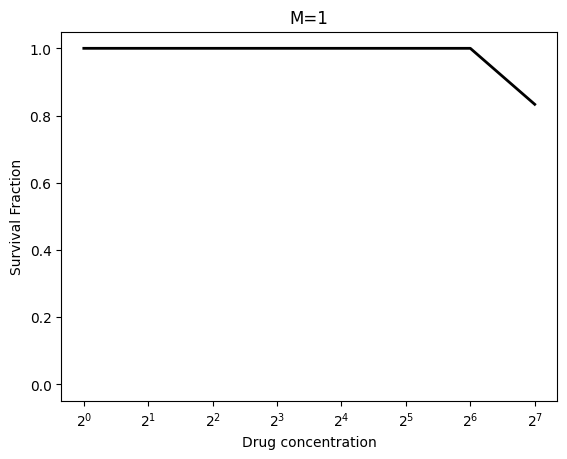

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


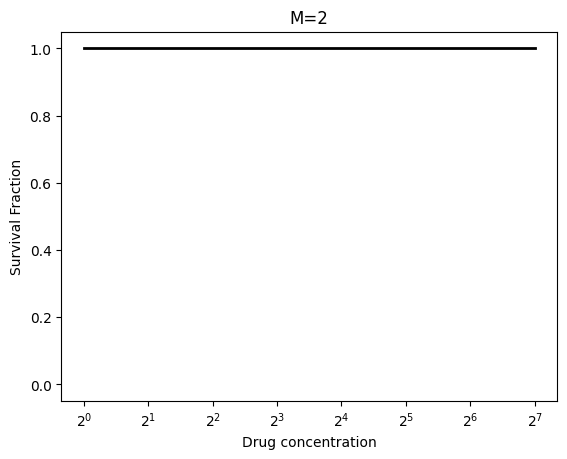

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


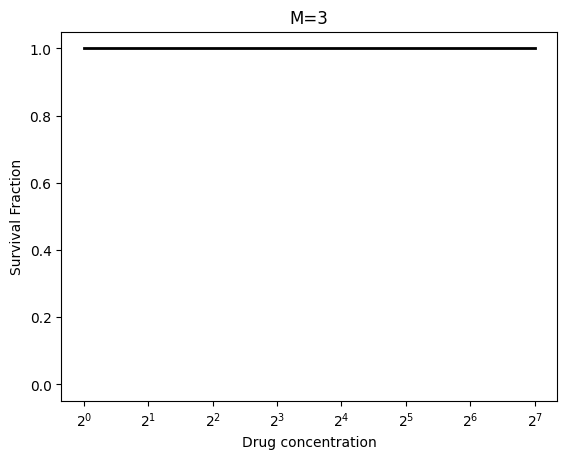

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


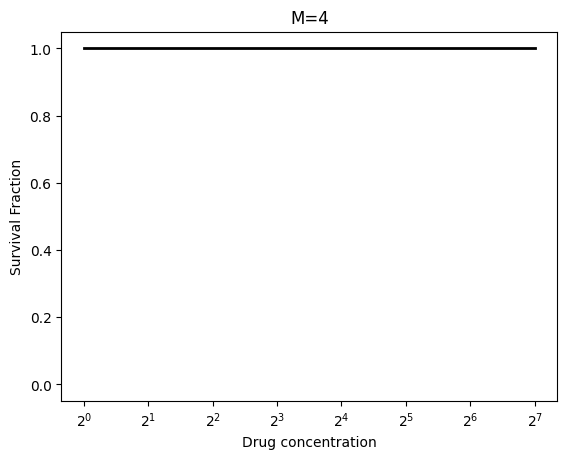

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


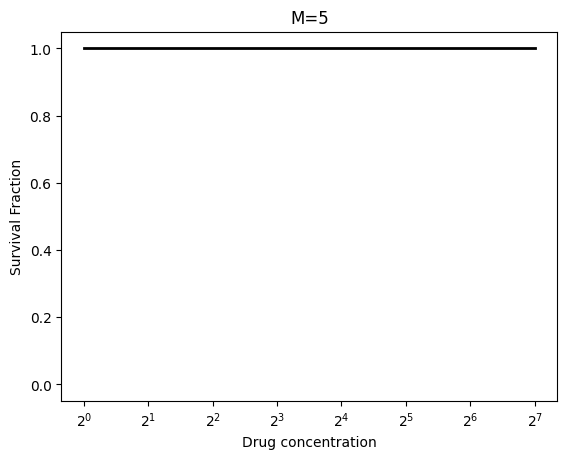

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


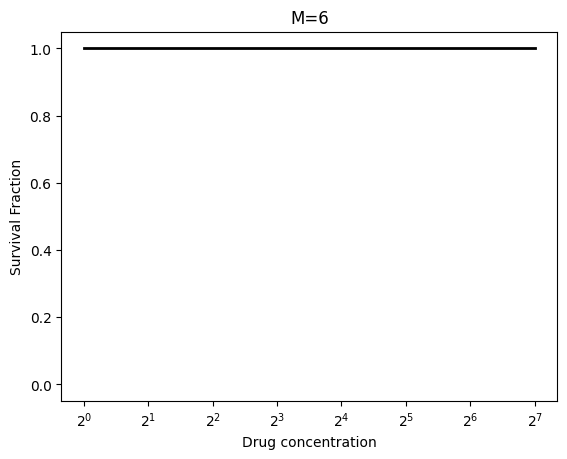

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


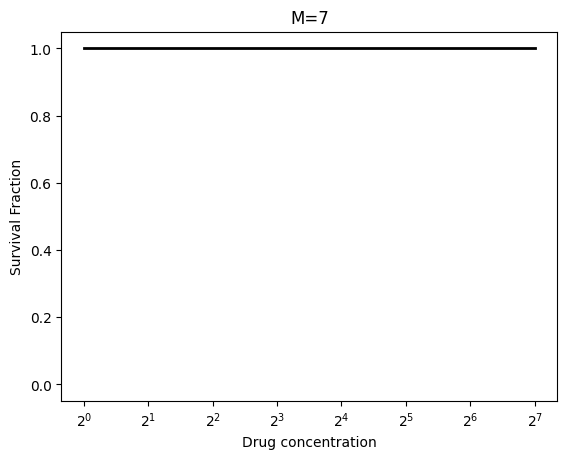

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


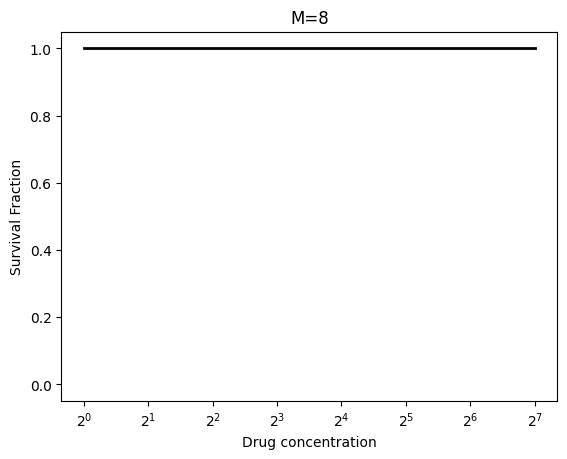

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


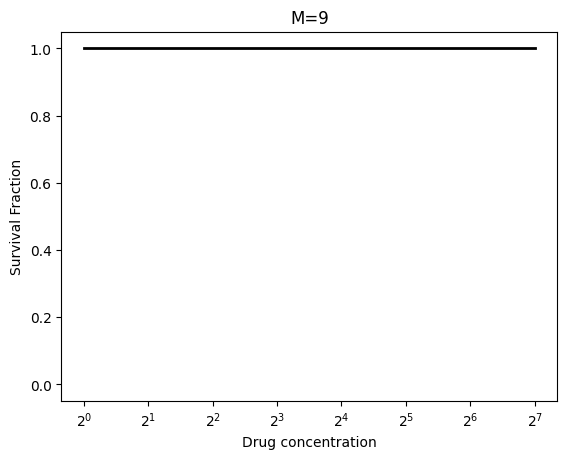

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


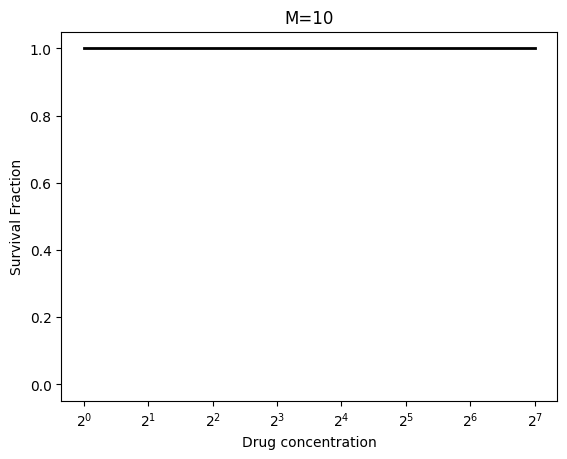

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


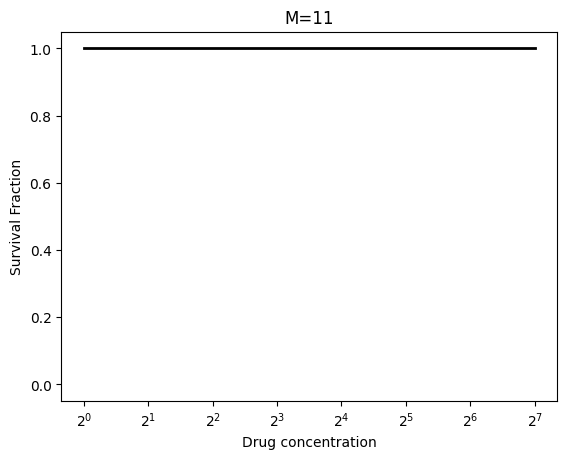

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


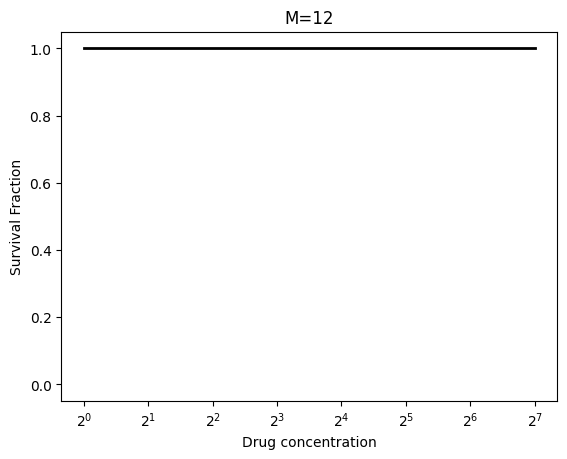

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


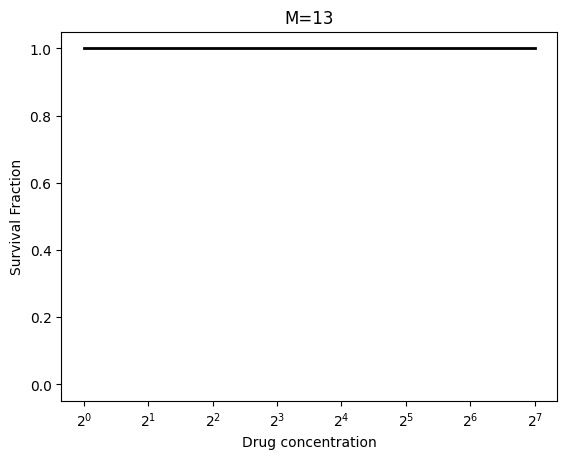

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


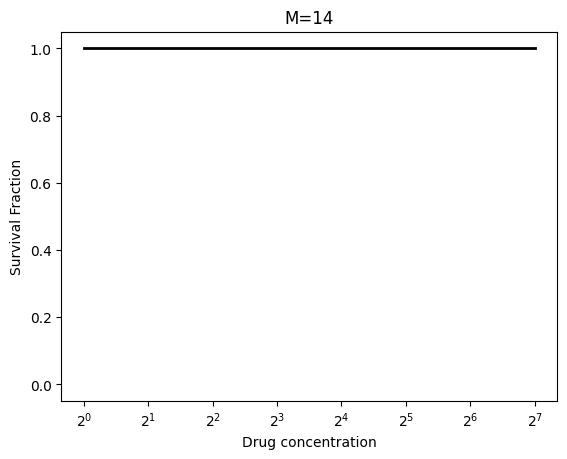

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


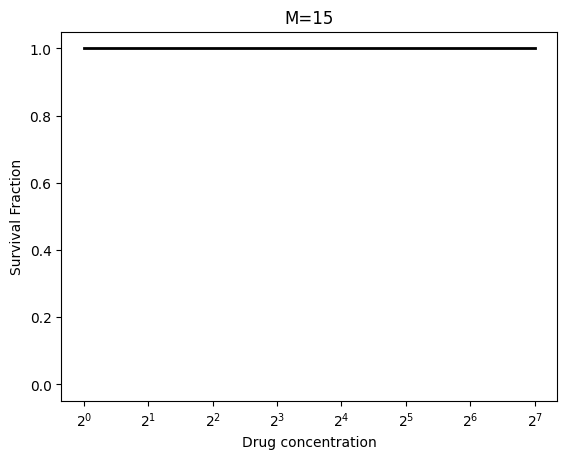

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


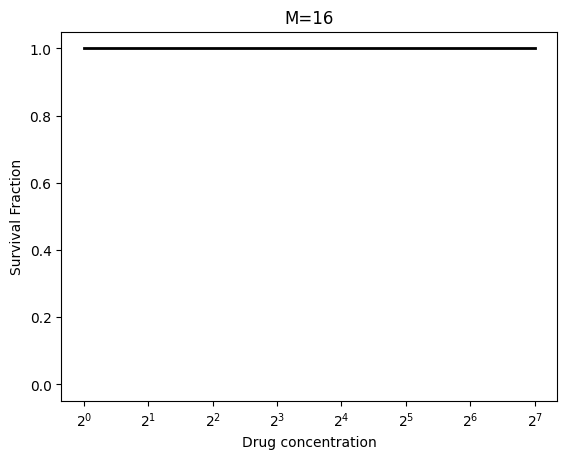

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


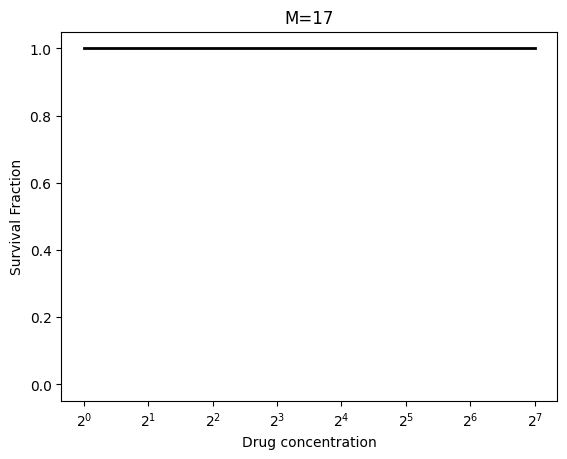

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


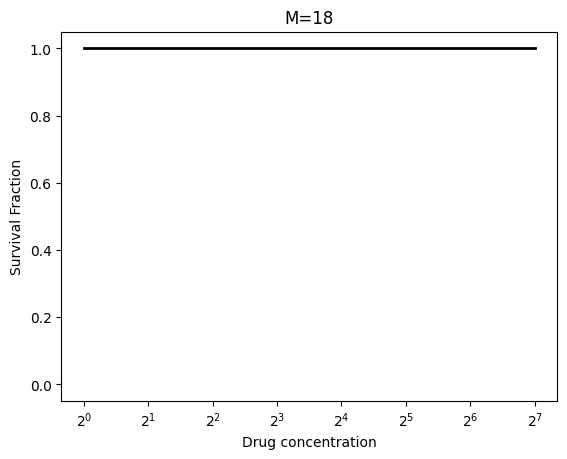

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


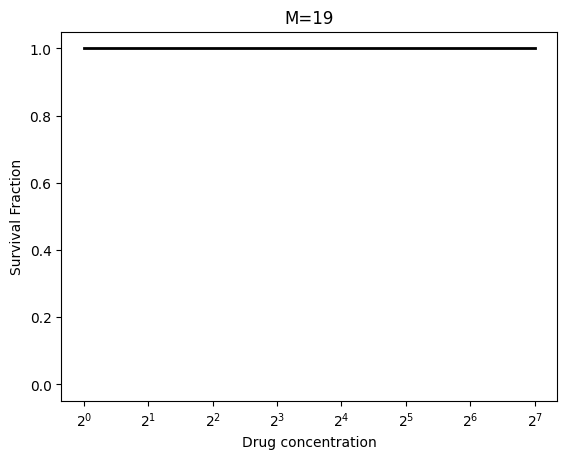

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


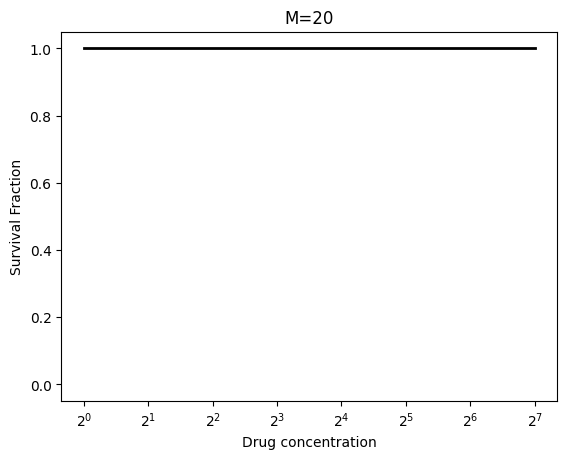

In [13]:
for M in M_values:

  load_and_plot_survival(M, Amax_values, verbose=False)

In [14]:
def load_and_plot_Ms_density(M_values, Amax, verbose=False):
    expe_Btots = []
    expe_BpEs = []
    expe_BpKs = []
    expe_Ms = []

    runPath = './runs/Gaussian_N%s_A%s/' % (num_days, Amax)
    if not os.path.isdir(runPath):
        print(f"Directory {runPath} does not exist. Skipping.")
        return

    expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))
    print("ALL=",expe_istrains)
    for M in M_values:
        for iexpe in range(np.min([len(expe_istrains),num_experiments])):
            this_istrains = expe_istrains[iexpe]
            this_istrains = this_istrains[:M]  # Select M strains
            str_subset = [str(x) for x in this_istrains]  # Convert all elements to string
            sim_lbl = "_".join(str_subset)  # Join elements with "_"
            fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
            filePath = "%s%s" % (runPath, fileName)
            if os.path.isfile(filePath):
                this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_freqpEs, this_freqpKs  = load_simulation_results(filePath)
                if verbose:
                    print("%s: Loading %s" % (iexpe, filePath))

                for j in range(len(this_Btot)):
                    expe_Btots.append(this_Btot[j][-1])  # last value of Btot
                    expe_BpEs.append(this_BpEs[j][-1])  # last value of BpEs
                    expe_BpKs.append(this_BpKs[j][-1])  # last value of BpKs
                    expe_Ms.append(M)
            else:
                if verbose:
                    print("Not found %s" % (filePath))

    plot_final_fraction_Ms_density(expe_Ms, expe_Btots, expe_BpEs, expe_BpKs, Amax)

def plot_final_fraction_Ms_density(expe_Ms, expe_Btots, expe_BpEs, expe_BpKs, Amax):
    jitter = 0.2
    # Create a jittered x-values
    expe_Ms_jittered = expe_Ms + np.random.uniform(-jitter, jitter, size=len(expe_Ms))

    # Create the scatter plot
    plt.scatter(expe_Ms_jittered, expe_Btots, alpha=0.1, color='black', label='Btots')
    plt.scatter(expe_Ms_jittered, expe_BpEs, alpha=0.1, color='red', label='BpEs')
    plt.scatter(expe_Ms_jittered, expe_BpKs, alpha=0.1, color='blue', label='BpKs')

    # Calculate the mean for each unique M value
    unique_Ms = np.unique(expe_Ms)
    mean_Btots = [np.mean(np.array(expe_Btots)[np.array(expe_Ms) == M]) for M in unique_Ms]
    mean_BpEs = [np.mean(np.array(expe_BpEs)[np.array(expe_Ms) == M]) for M in unique_Ms]
    mean_BpKs = [np.mean(np.array(expe_BpKs)[np.array(expe_Ms) == M]) for M in unique_Ms]

    # Plot the mean frequencies
    plt.scatter(unique_Ms, mean_Btots, color='black')
    plt.scatter(unique_Ms, mean_BpEs, color='red')
    plt.scatter(unique_Ms, mean_BpKs, color='blue')

    # Add labels to the axes
    plt.xlabel('Community Size (M)')
    plt.ylabel('Bacterial density')
    plt.xticks(range(1+len(np.unique(expe_Ms))))
    plt.xlim([0.5, 0.5+len(np.unique(expe_Ms))])

    # Add a title to the plot
    plt.title('Amax=%s' % (Amax))

    plt.legend()
    # Display the plot
    plt.show()


ALL= [[39, 43, 34, 29, 45, 20, 41, 26, 38, 24, 37, 1, 11, 2, 21, 6, 15, 25, 9, 18], [38, 43, 37, 34, 20, 39, 25, 11, 45, 15, 9, 26, 18, 1, 21, 24, 6, 41, 2, 29], [24, 18, 21, 6, 37, 45, 38, 26, 25, 11, 1, 41, 29, 34, 2, 15, 9, 20, 39, 43], [24, 25, 45, 18, 11, 9, 34, 1, 6, 37, 39, 21, 41, 26, 2, 20, 15, 38, 43, 29]]


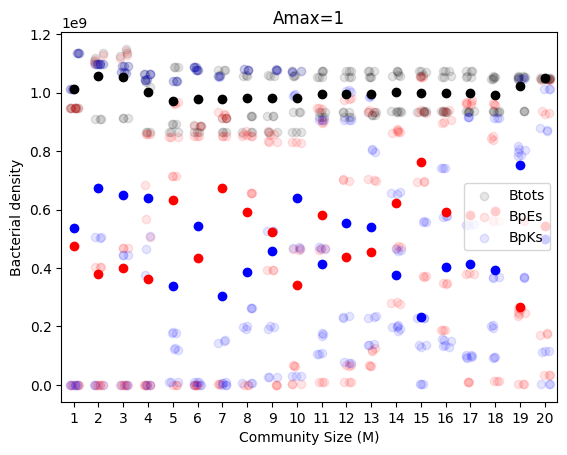

ALL= [[18, 24, 37, 39, 43, 21, 45, 29, 41, 15, 11, 2, 34, 20, 25, 26, 9, 1, 6, 38], [25, 2, 20, 34, 9, 11, 18, 39, 41, 15, 37, 24, 21, 6, 1, 29, 38, 45, 43, 26], [39, 6, 15, 18, 21, 24, 41, 26, 34, 45, 38, 43, 20, 37, 2, 1, 11, 9, 25, 29], [26, 38, 21, 18, 37, 45, 11, 34, 1, 20, 39, 24, 2, 9, 29, 25, 43, 15, 6, 41]]


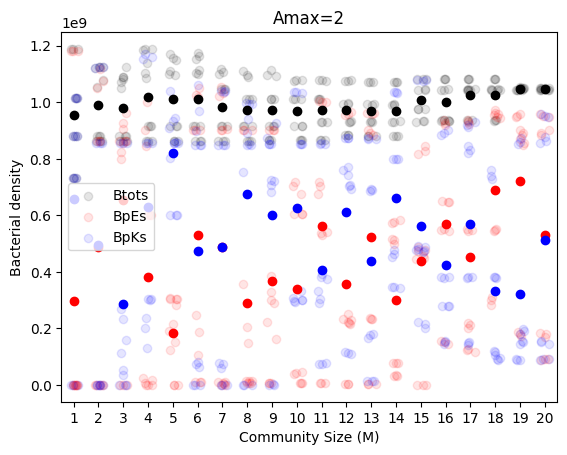

ALL= [[39, 26, 1, 37, 6, 21, 2, 18, 29, 45, 9, 34, 25, 24, 38, 20, 11, 41, 15, 43], [24, 1, 2, 43, 18, 26, 25, 45, 29, 38, 15, 6, 9, 11, 34, 20, 21, 37, 41, 39], [29, 39, 41, 6, 37, 15, 25, 21, 45, 20, 18, 38, 26, 34, 1, 43, 9, 11, 24, 2], [1, 39, 43, 25, 21, 37, 11, 38, 34, 2, 29, 45, 6, 9, 15, 18, 26, 41, 20, 24]]


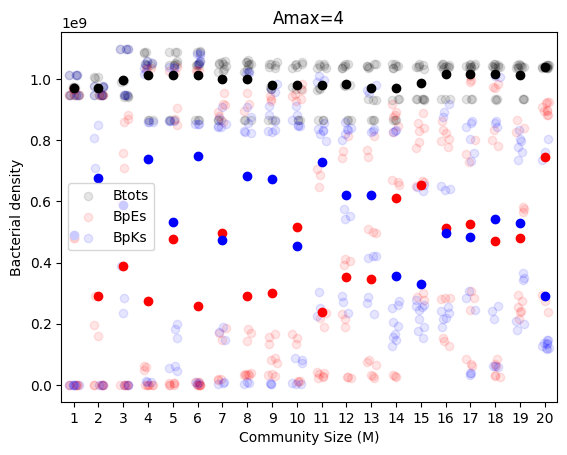

ALL= [[37, 20, 26, 41, 6, 21, 34, 2, 18, 15, 29, 9, 43, 45, 38, 24, 11, 25, 39, 1], [24, 18, 38, 29, 1, 20, 25, 26, 2, 39, 43, 11, 34, 45, 15, 6, 9, 21, 37, 41], [43, 26, 1, 45, 9, 2, 6, 34, 20, 41, 25, 29, 39, 37, 11, 38, 18, 24, 21, 15], [20, 45, 26, 11, 41, 6, 34, 9, 29, 37, 15, 21, 43, 1, 25, 38, 2, 24, 18, 39]]


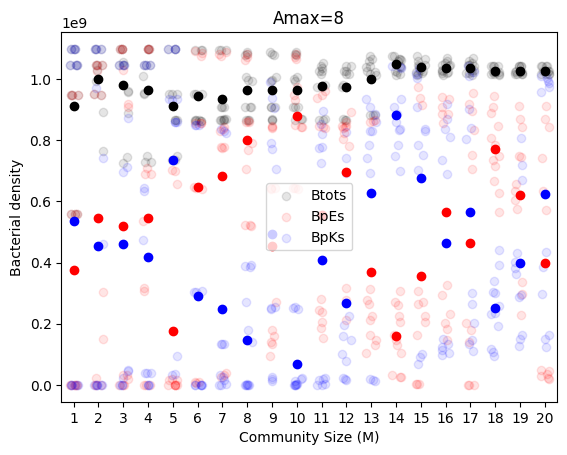

ALL= [[11, 37, 29, 9, 20, 18, 26, 21, 24, 2, 38, 34, 15, 25, 43, 1, 41, 6, 39, 45], [2, 34, 25, 41, 43, 39, 21, 9, 37, 29, 26, 11, 15, 6, 45, 1, 24, 20, 38, 18], [39, 43, 25, 34, 20, 38, 24, 15, 18, 9, 29, 11, 6, 45, 1, 26, 21, 2, 37, 41], [20, 25, 21, 45, 37, 18, 39, 34, 38, 2, 26, 43, 41, 15, 9, 29, 11, 6, 24, 1]]


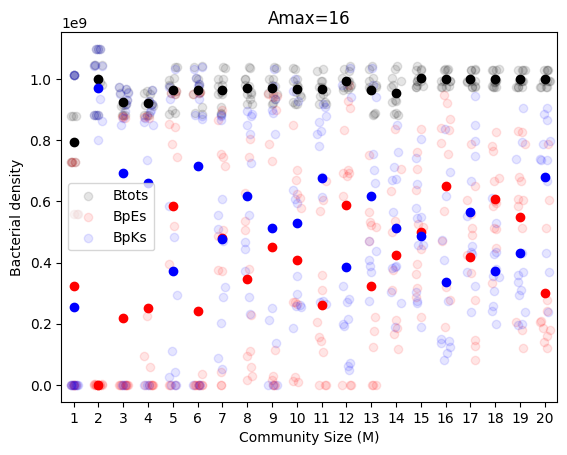

ALL= [[34, 37, 25, 15, 11, 45, 21, 9, 18, 41, 20, 2, 29, 43, 38, 6, 1, 26, 24, 39], [9, 25, 41, 37, 20, 45, 21, 1, 18, 43, 39, 26, 2, 34, 6, 11, 15, 29, 24, 38], [39, 11, 37, 20, 38, 1, 6, 9, 25, 34, 18, 29, 45, 24, 2, 43, 15, 26, 21, 41], [18, 26, 25, 24, 2, 29, 38, 39, 37, 34, 6, 43, 11, 1, 15, 21, 9, 41, 45, 20]]


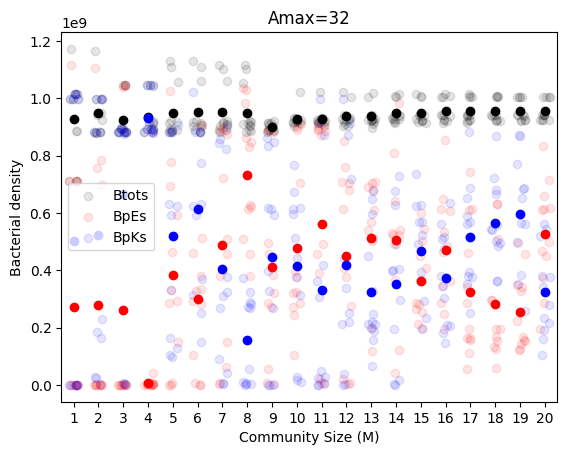

ALL= [[45, 26, 41, 39, 18, 2, 1, 43, 20, 15, 38, 34, 9, 11, 21, 24, 6, 37, 25, 29], [25, 38, 6, 11, 20, 24, 15, 43, 1, 41, 9, 2, 39, 29, 26, 37, 21, 34, 45, 18], [18, 11, 41, 39, 37, 6, 26, 29, 15, 2, 21, 24, 38, 25, 34, 20, 1, 45, 9, 43], [9, 37, 20, 43, 45, 34, 26, 25, 1, 21, 29, 38, 18, 6, 11, 2, 39, 15, 41, 24]]


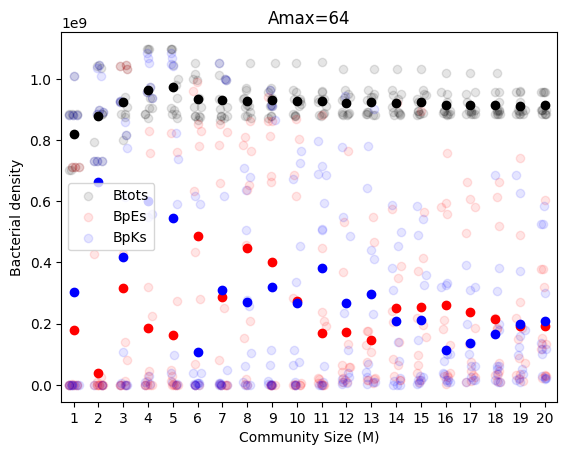

ALL= [[2, 38, 26, 34, 1, 11, 37, 45, 6, 41, 43, 25, 20, 9, 15, 21, 24, 39, 18, 29], [37, 26, 18, 20, 38, 21, 29, 45, 41, 15, 1, 11, 25, 2, 43, 9, 6, 39, 24, 34], [15, 2, 25, 45, 34, 9, 38, 29, 11, 20, 24, 26, 37, 6, 43, 18, 1, 41, 21, 39], [24, 25, 45, 29, 41, 38, 20, 15, 11, 21, 1, 18, 34, 6, 39, 43, 26, 2, 9, 37]]


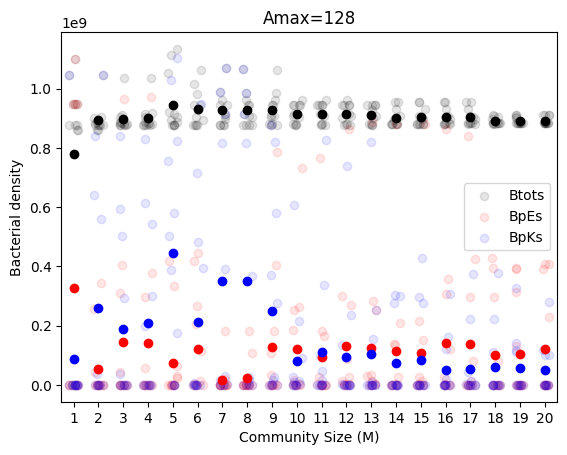

In [15]:

for A in Amax_values:
    load_and_plot_Ms_density(M_values, A, verbose=False)


In [16]:
def load_PF_M(M_values, Amax, verbose=False):

    final_pf=[]
    final_M=[]
    final_expe=[]
    stabilizing_strains=[]

    runPath = './runs/Gaussian_N%s_A%s/' % (num_days, Amax)
    if not os.path.isdir(runPath):
        print(f"Directory {runPath} does not exist. Skipping.")
        return final_expe, final_M, final_pf, stabilizing_strains

    expe_istrains = get_sequences_from_files(runPath, length=len(strains_subset))

    for iexpe in range(np.min([num_experiments, len(expe_istrains)])):
        for this_istrains in [expe_istrains[iexpe]]:
            if verbose:
                print(this_istrains)

            unstable = [True]*len(expe_istrains)

            for M in M_values:
                M_istrains = this_istrains[:M]  # fix M value
                str_subset = [str(x) for x in M_istrains]  # Convert all elements to string
                sim_lbl = "_".join(str_subset)  # Join elements with "_"
                fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename
                filePath = "%s%s" % (runPath, fileName)
                if os.path.isfile(filePath):
                    this_subset, this_Es, this_Btot, this_BpEs, this_BpKs, this_freqpEs, this_freqpKs  = load_simulation_results(filePath)
                    if verbose:
                        print("%s: Loading %s" % (M, filePath))

                    for j in range(len(this_Btot)):
                        this_Bp = this_BpEs[j][-1] + this_BpKs[j][-1] # final Bp value
                        this_density = this_Btot[j][-1] # final total density

                        if this_density > 1:  # tmp
                            this_final_pf = this_Bp / this_density
                        else:
                            print("Extinction!")
                            this_final_pf = np.nan

                        if verbose:
                            print('\t',this_Bp, ' / ', this_density, ' = ', np.round(100*this_final_pf),'%')
                        final_pf.append(this_final_pf)
                        final_M.append(M)
                        final_expe.append(iexpe)

                        if unstable[iexpe]==True:
                            if this_final_pf>0.99: #plasmid stable
                                if verbose:
                                    print("*** Stabilizing strain: %s %s"%(iexpe, M_istrains[-1]))
                                stabilizing_strains.append(M_istrains[-1])
                                unstable[iexpe]=False
                else:
                    if verbose:
                        print("Not found %s" % (filePath))
    return final_expe, final_M, final_pf, stabilizing_strains

def plot_M_v_PF(final_expe, final_M, final_pf):
    # Get unique experiment indices
    unique_expe = list(set(final_expe))

    # Initialize plot
    plt.figure(figsize=(6, 4))  # Adjust the size as needed

    # Loop over unique experiment indices and plot each line separately
    for expe in unique_expe:
        # Get M and pf values for this experiment
        M_values = [final_M[i] for i in range(len(final_expe)) if final_expe[i] == expe]
        pf_values = [final_pf[i] for i in range(len(final_expe)) if final_expe[i] == expe]

        # Plot M vs pf for this experiment
        plt.plot(M_values, pf_values,'-') #, label=f"Experiment {expe}"

    # Add legend, labels, and title
    #plt.legend()
    plt.xlabel("Size of community (M)")
    plt.ylabel("Final plasmid fraction")
    plt.ylim([-0.05, 1.05])
    plt.show()


In [17]:
def create_stabilizing_matrix(strains, counts_Amax):
    # Initialize an empty matrix with dimensions (number_of_strains x number_of_Amax_values)
    matrix = np.zeros((len(strains), len(counts_Amax)))

    # Loop over each Amax value
    for i, count in enumerate(counts_Amax):
        # Loop over each strain
        for j, strain in enumerate(strains):
            # If the strain was a stabilizing strain for this Amax value, store the count in the matrix
            if j in count:
                matrix[j, i] = count[j]

    return matrix




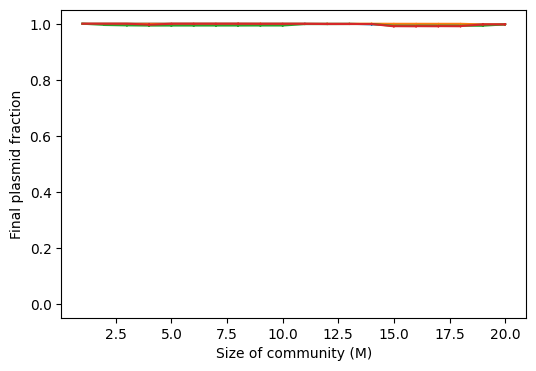

Stabilizing strains (Amax=1):
	C324: 2
	K216: 1
	K213: 1


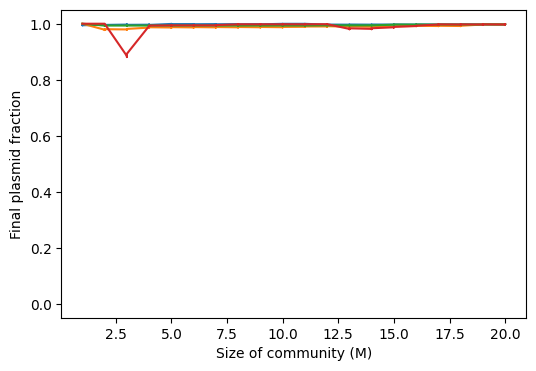

Stabilizing strains (Amax=2):
	C247: 1
	K037: 1
	K216: 1
	K038: 1


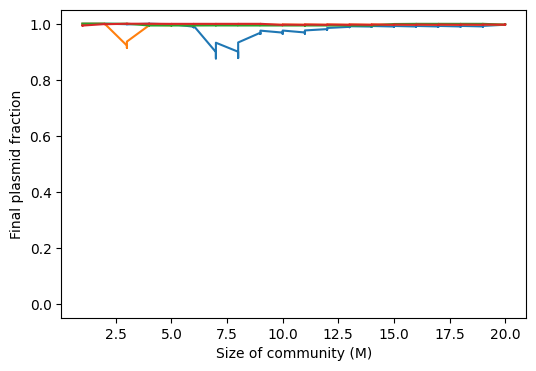

Stabilizing strains (Amax=4):
	K216: 1
	C324: 1
	K112: 1
	C002: 1


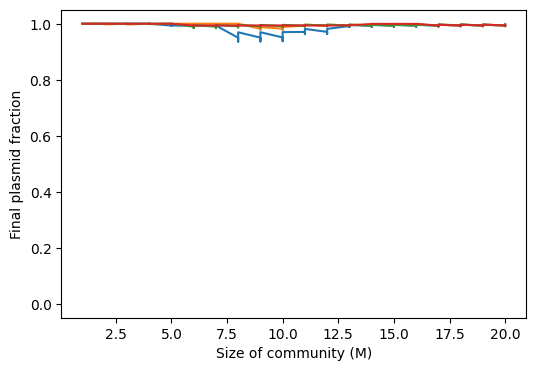

Stabilizing strains (Amax=8):
	K209: 1
	C324: 1
	K248: 1
	C286: 1


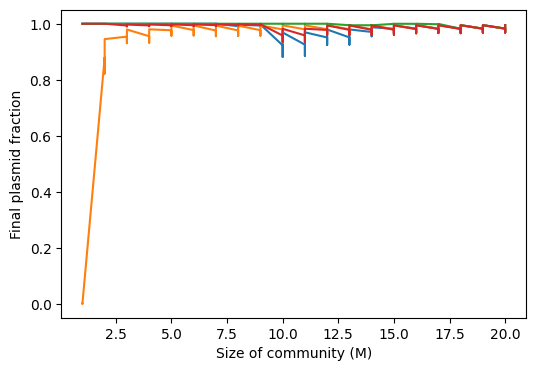

Stabilizing strains (Amax=16):
	C107: 1
	K248: 1
	K216: 1
	C286: 1


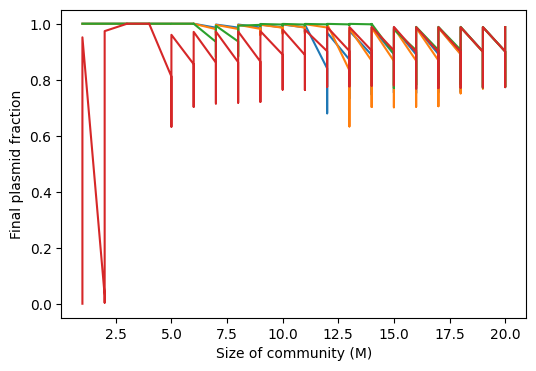

Stabilizing strains (Amax=32):
	K177: 1
	C063: 1
	K216: 1
	K037: 1


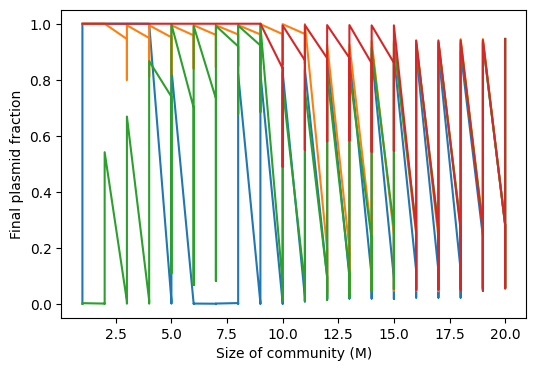

Stabilizing strains (Amax=64):
	K253: 1
	K037: 1
	K209: 1
	C063: 1
Extinction!
Extinction!


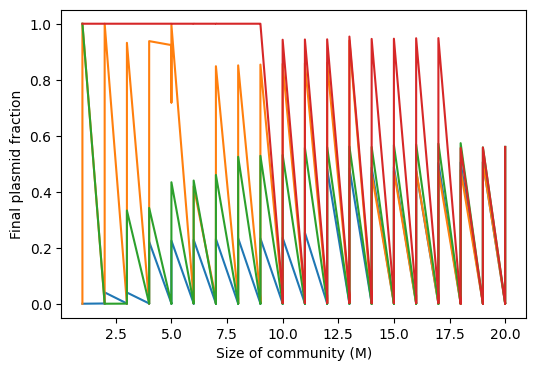

Stabilizing strains (Amax=128):
	K209: 1
	C201: 1
	C324: 1


In [18]:


#powers = np.arange(1,4)  # array of powers of two exponents
#Amax_values=np.power(2, powers)  # calculate 2 raised to each exponent
#M_values=range(1,10)

counts_Amax=[]
for Amax in Amax_values:

   # Call the load_PF_M function to run the simulation and get results
   # This function also returns the stabilizing_strains for each run
   final_expe, final_M, final_pf, stabilizing_strains = load_PF_M(M_values, Amax, verbose=False)

   # Plot the results of M vs PF
   plot_M_v_PF(final_expe, final_M, final_pf)

   # Create a Counter object to count the occurrence of each stabilizing strain
   count_stabilizing_strains = Counter(stabilizing_strains)

   # Print the stabilizing strains and their counts for this Amax value
   print("Stabilizing strains (Amax=%s):"%Amax)
   for element, count in count_stabilizing_strains.most_common():
     print(f"\t{strains[element]}: {count}")

   # Append the counter to the list of all counters
   counts_Amax.append(count_stabilizing_strains)

# After looping over all Amax values and storing the counters,
# create the stabilizing matrix using the create_stabilizing_matrix function
# This matrix has a row for each strain and a column for each Amax value
# Each cell contains the number of times the strain (row) was a stabilizing strain for the Amax value (column)
stabilizing_matrix = create_stabilizing_matrix(strains, counts_Amax)


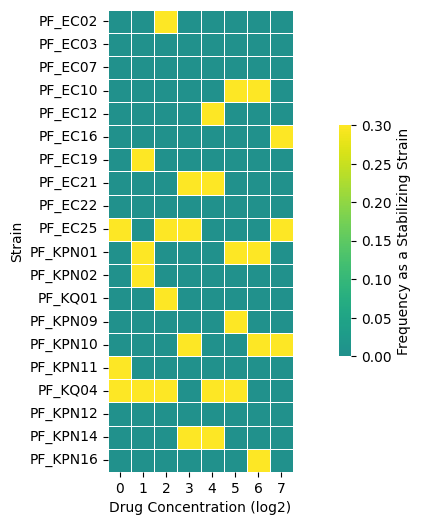

In [19]:


def plot_heatmap(model_params, strains_subset, stabilizing_matrix):
    # Subset the stabilizing matrix to only include rows in the strains_subset
    stabilizing_matrix_subset = stabilizing_matrix[strains_subset, :]
    strains_name = [model_params['strain_name'][i] for i in strains_subset]

    # Check if the subset is empty
    if stabilizing_matrix_subset.size == 0:
        print("The subset is empty.")
        return

    # Convert the numpy array to a pandas DataFrame
    stabilizing_df = pd.DataFrame(stabilizing_matrix_subset, index=strains_subset)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 6))

    # Draw the heatmap with the mask and correct aspect ratio
    cbar_kws = {"shrink": .5, 'label': 'Frequency as a Stabilizing Strain'}
    sns.heatmap(stabilizing_df, cmap="viridis", vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws=cbar_kws)

    ax.set_yticks(np.arange(stabilizing_df.shape[0])+0.5, minor=False)
    ax.set_yticklabels(strains_name, minor=False)
    plt.yticks(rotation=0)  # Rotate y-labels
    ax.set_xlabel('Drug Concentration (log2)')
    ax.set_ylabel('Strain')

    # Show the plot
    plt.show()

plot_heatmap(model_params, strains_subset, stabilizing_matrix)


In [20]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler

def plot_growthParams(model_params, strains_subset, Amax_index, stabilizing_matrix, ax):
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    num_half = int(len(VKm_values)/2)

    # Get the number of times each strain was a stabilizing strain at the specified Amax
    stabilizing_counts = stabilizing_matrix[:, Amax_index]

    # Initialize a MinMaxScaler to scale the counts
    scaler = MinMaxScaler(feature_range=(10, 1000))

    # Fit the scaler to the counts and transform the counts
    marker_sizes = scaler.fit_transform(stabilizing_counts.reshape(-1, 1)).flatten()

    # Define the markers for each specie
    markers = {'E': 's', 'K': 'o'}

    # Iterate over each strain and plot it with the corresponding color and marker
    for i in range(num_half):
      if i in strains_subset:
        ax.scatter(rho_values[i], VKm_values[i], s=marker_sizes[i],
                    marker=markers[model_params['specie'][i]],
                    color=model_params['strain_color'][i], label=model_params['specie'][i], alpha=0.5)
      else:
        ax.scatter(rho_values[i], VKm_values[i], s=marker_sizes[i],
                    marker=markers[model_params['specie'][i]],
                    edgecolors='k', label=model_params['specie'][i], alpha=0.25, facecolor='none')


    ax.set_xlabel(r'Resource conversion rate ($\rho$)', fontsize=16)
    ax.set_ylabel(r'Specific affinity ($V_{\mathrm{max}}/Km$)', fontsize=16)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Create custom handles for the legend
    handles = [Line2D([0], [0], marker='s', color='none', label='E', markerfacecolor='white', markersize=8),
               Line2D([0], [0], marker='o', color='none', label='K', markerfacecolor='white', markersize=8)]
    ax.legend(handles=handles)



In [21]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import ScalarFormatter, LogLocator

def plot_conjParams(model_params,  strains_subset, Amax_index, stabilizing_matrix, ax):
    kappa_values = model_params['kappa']
    conj_rate_values = np.nan_to_num(model_params['conj_rate'], nan=5e-8)  # replace nan values with a very small positive number
    num_half = int(len(kappa_values)/2)

    # Get the number of times each strain was a stabilizing strain at the specified Amax
    stabilizing_counts = stabilizing_matrix[:, Amax_index]

    # Initialize a MinMaxScaler to scale the counts
    scaler = MinMaxScaler(feature_range=(20, 1000))

    # Fit the scaler to the counts and transform the counts
    marker_sizes = scaler.fit_transform(stabilizing_counts.reshape(-1, 1)).flatten()

    # Define the markers for each specie
    markers = {'E': 's', 'K': 'o'}



    # Iterate over each strain and plot it with the corresponding color and marker
    for i in range(num_half):
      if i in strains_subset:
        ax.scatter(conj_rate_values[i+num_half], kappa_values[i], s=marker_sizes[i],
                    marker=markers[model_params['specie'][i]],
                    color=model_params['strain_color'][i], label=model_params['specie'][i], alpha=0.5)


    ax.set_xlabel(r'Conjugation rate', fontsize=16)
    ax.set_ylabel(r'Resistance level ($\kappa$)', fontsize=16)

    ax.set_xlim([2e-8,5e-1])
    ax.set_xscale('log', base=10)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xticks([5e-8, 1e-6, 1e-4, 1e-2])
    ax.set_xticklabels(['0', '1e-6', '1e-4', '1e-2'])
#    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())



    ax.set_yscale('log', base=2)
    ax.set_ylim([2**-14,2**-8])
    ax.tick_params(axis='y', labelsize=14)
    #ax.yaxis.set_major_locator(LogLocator(base=2))
    #ax.yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(0.1, 1.0, 0.1), numticks=10))

    # Create custom handles for the legend
    handles = [Line2D([0], [0], marker='s', color='none', label='E', markerfacecolor='white', markersize=8),
               Line2D([0], [0], marker='o', color='none', label='K', markerfacecolor='white', markersize=8)]
    ax.legend(handles=handles)





Amax=1


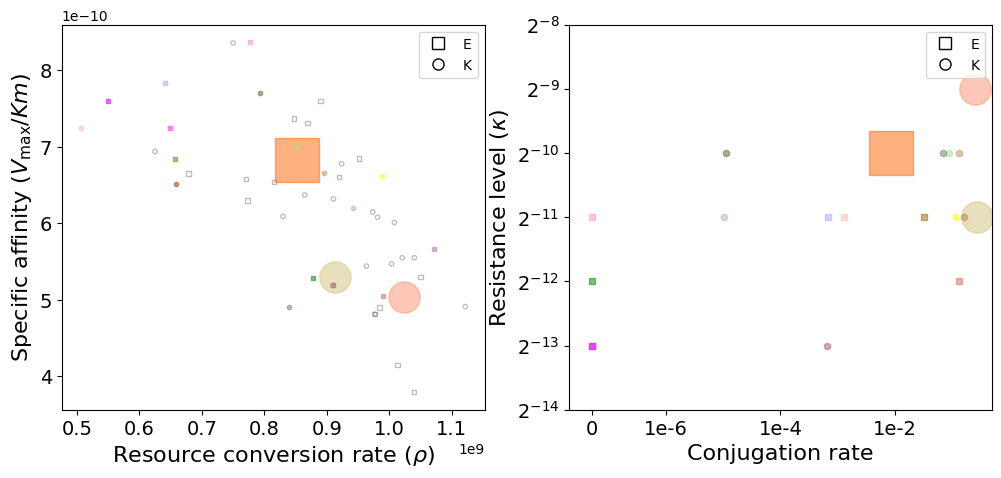

Amax=2


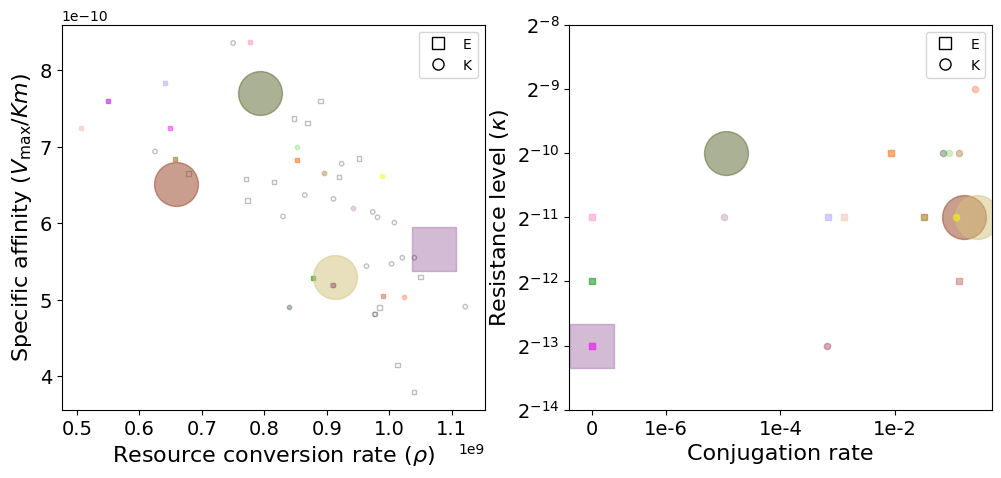

Amax=4


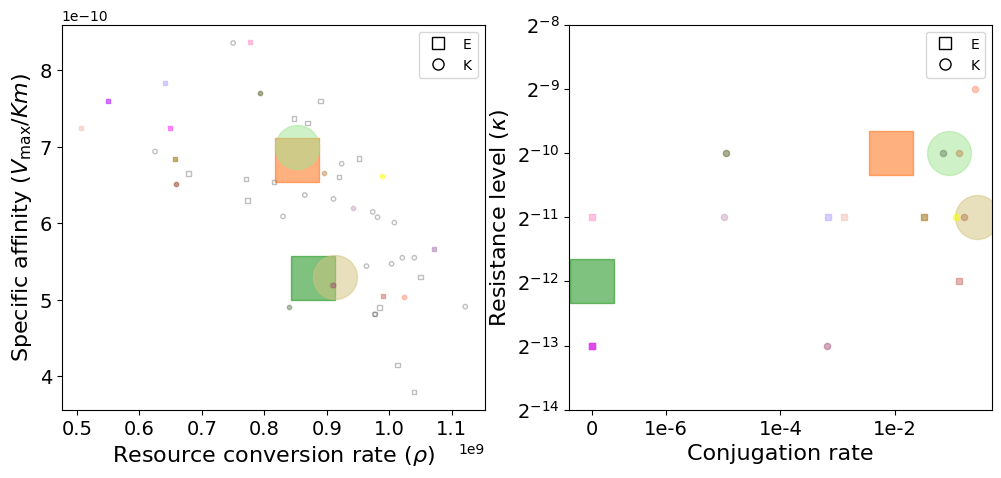

Amax=8


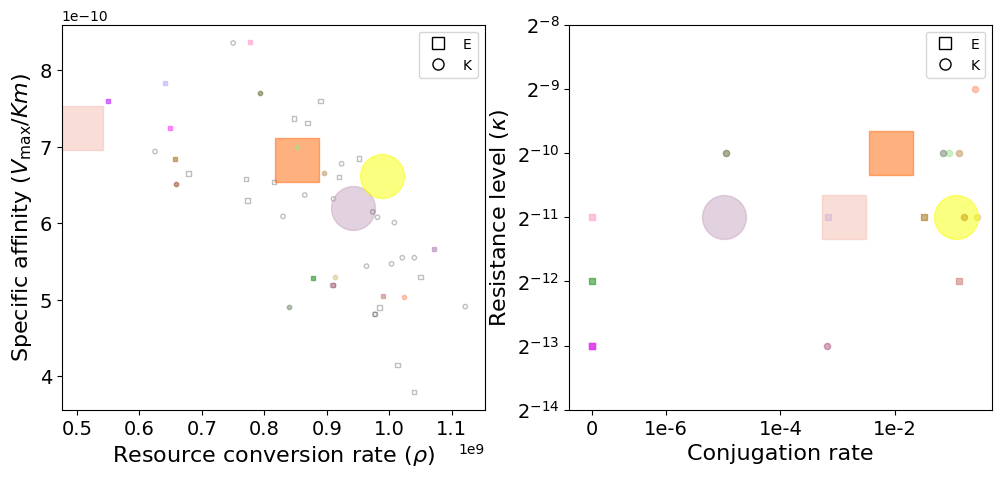

Amax=16


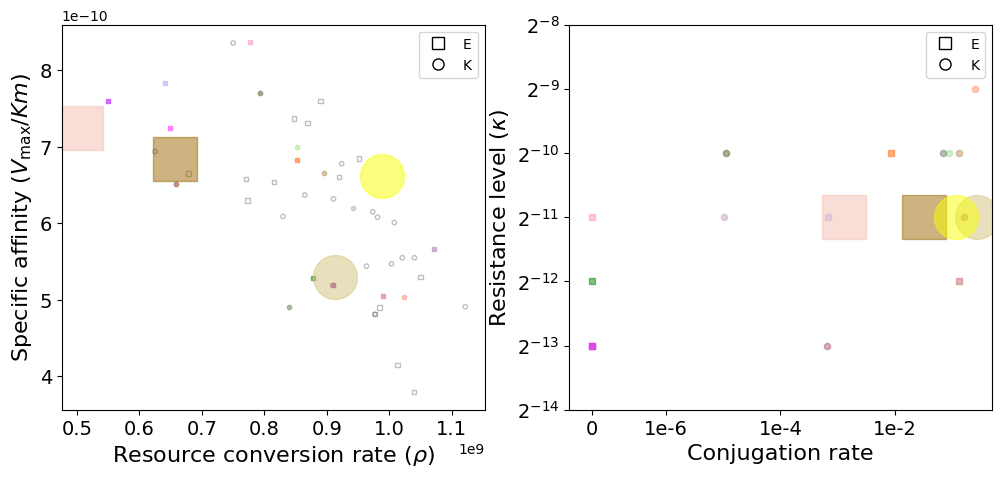

Amax=32


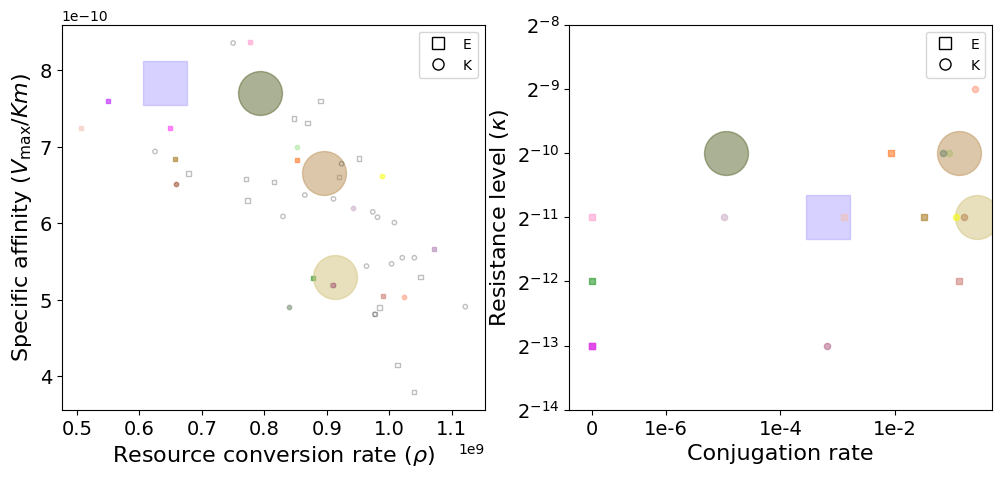

Amax=64


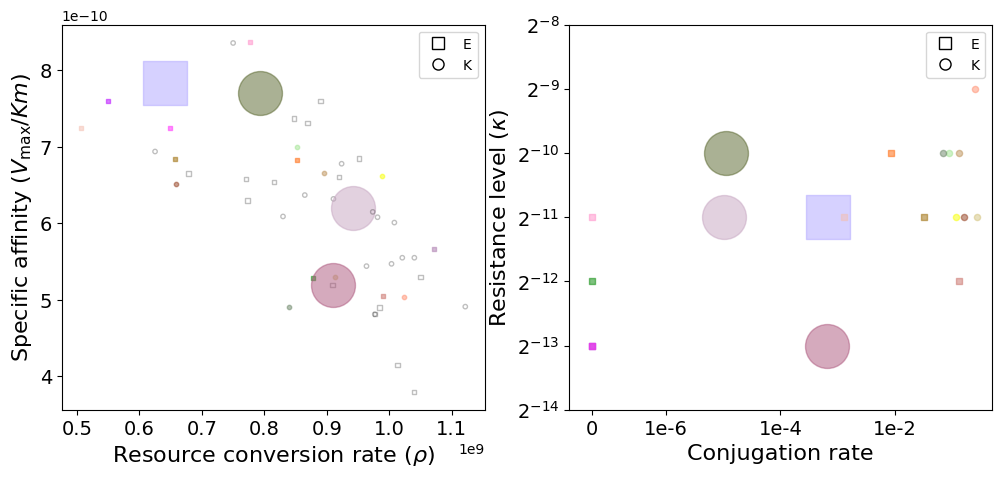

Amax=128


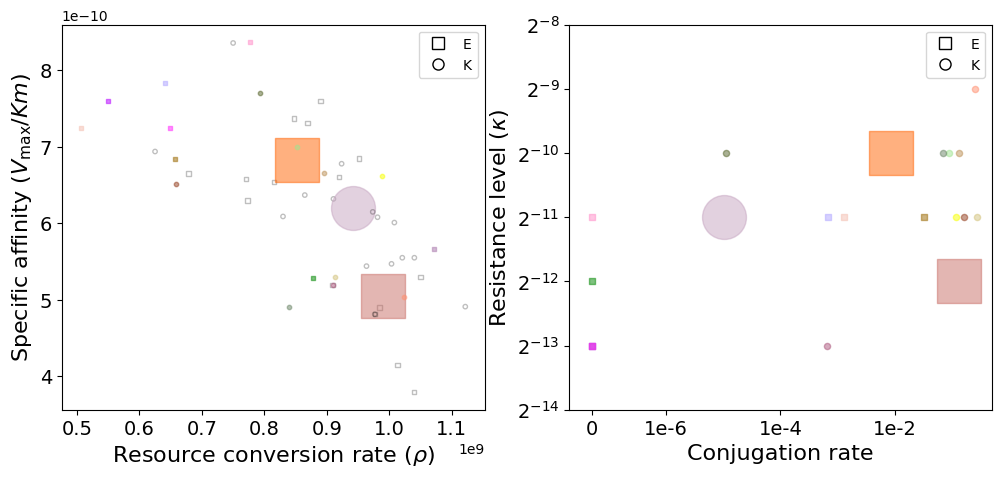

In [22]:

for Amax_index, Amax in enumerate(Amax_values):
  print("Amax=%s"%Amax)

  f, axs = plt.subplots(1,2, figsize=(12, 5))
  plot_growthParams(model_params, strains_subset, Amax_index, stabilizing_matrix, axs[0])
  plot_conjParams(model_params,  strains_subset, Amax_index, stabilizing_matrix, axs[1])
  plt.show()